# Deep Belief Modeling
Project for SI course

## Imports

In [22]:
import pickle
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from collections import Counter
from minisom import MiniSom
from copy import deepcopy

from preprocessing.vectors import prepare_dictionary,generate_vectors, find_close_words
from som.plot import plot_vectors
from preprocessing.article import random_percent
from model.features import f_importances
from preprocessing.article import word_preprocess

## Loading data

In [23]:
articles = pd.read_csv("resources/data.csv", sep="\t")

## Input data visualisation

<AxesSubplot:title={'center':'Rozkład artykułów'}, xlabel='Rodzaj artykułów', ylabel='Liczba artykułów'>

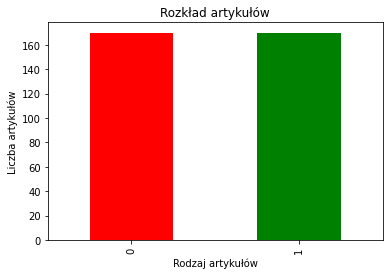

In [24]:
x = articles["label"].value_counts()
x.plot(kind="bar", color=["r", "g"],title="Rozkład artykułów",ylabel="Liczba artykułów",xlabel="Rodzaj artykułów")

## Text pre-processing for classification

In [25]:
print(articles["data"].head(10))
print(articles["data"].head(10).apply(word_preprocess))

0    It's been quite a week. I've been in the media...
1    This week has been eye-opening. Even for me --...
2    Yes, it's true. I beat COVID-19 in 48 hours wi...
3    The COVID-19 vaccines appear to be causing a g...
4    Back in the 1980s, I was a Columbia University...
5    So you got the vaccine because they told you t...
6    I Am A Living Proof That COVID-19 Is Fake This...
7    I have a PhD in virology and immunology. I’m a...
8    How do you convince the world’s population to ...
9    Take 15 minutes and listen to this interview w...
Name: data, dtype: object
0    [quite, week, medium, business, decade, never,...
1    [week, eye, opening, even, guy, warned, year, ...
2    [yes, true, beat, covid, hour, ivermectin, get...
3    [covid, vaccine, appear, causing, global, heal...
4    [back, columbia, university, student, learning...
5    [got, vaccine, told, get, forced, get, joe, bi...
6    [living, proof, covid, fake, unfiltered, take,...
7    [phd, virology, immunology, clinic

## Feature selection

### Pickle import

In [26]:
with open("model_storage/data_csv_ms/vectorizer.pkl","rb") as file:
    tfidf_vectorizer = pickle.load(file)

with open("model_storage/data_csv_ms/bow.pkl","rb") as file:
    tfidf_wm = pickle.load(file)

with open("model_storage/data_csv_ms/classifier.pkl","rb") as file:
    sgdc_classifier = pickle.load(file)

with open("model_storage/data_csv_ms/words_pa.pkl","rb") as file:
    words_pa = pickle.load(file)

tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

print(tfidf_tokens)

df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print("Tf-idf vectorizer")
print(df_tfidf_vect)


['aabduzrw' 'aaby' 'aadhaar' ... 'zoster' 'zuckerberg' 'zurich']
Tf-idf vectorizer
     aabduzrw  aaby  aadhaar  aaho  aamc  aamcnews  aap  aaphowever  aarogya  \
0         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
1         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
2         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
3         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
4         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
..        ...   ...      ...   ...   ...       ...  ...         ...      ...   
335       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
336       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
337       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
338       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
339       0.0   0.0      0.0   0.0   

### Plots

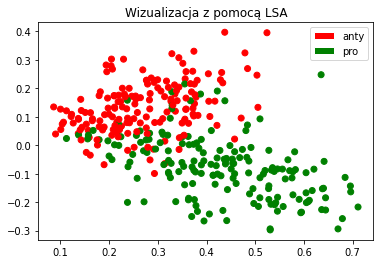

In [27]:
from matplotlib.patches import Patch

clftr = TruncatedSVD(2)
Xpca = clftr.fit_transform(tfidf_wm)
plt.title("Wizualizacja z pomocą LSA")

plt.scatter([x[0] for x in Xpca],[x[1] for x in Xpca],c=['r' if articles['label'][i] == 0 else 'g' for i,d in enumerate(Xpca)])
legend_elements = [Patch(facecolor='red', edgecolor='white',label='anty'),
                   Patch(facecolor='green', edgecolor='white',label='pro')]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

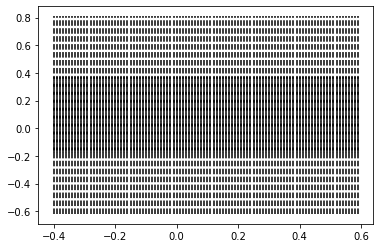

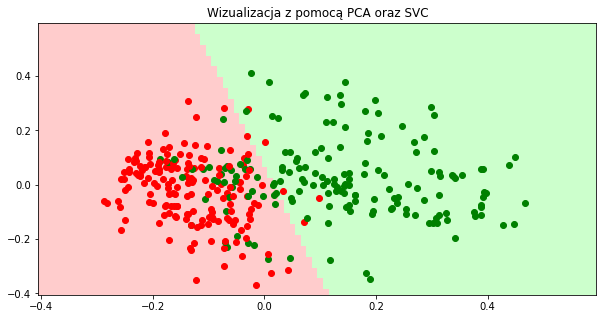

In [28]:
from sklearn.linear_model import SGDClassifier

h = .01
x_min, x_max = -0.4,0.6
y_min, y_max = -0.4,0.6
# loading dataset
X, y = tfidf_wm.toarray(), articles["label"]
# selecting first 2 components of PCA
X_selected = PCA(2).fit_transform(X)
# training classifier and evaluating on the whole plane
clf_sgd = SGDClassifier()
clf_sgd.fit(X_selected,y)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

w = clf_sgd.coef_[0]
a = -w[0] / w[1]

margin = 1 / np.sqrt(np.sum(clf_sgd.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

Z = clf_sgd.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('Wizualizacja z pomocą PCA oraz SVC')
for xy,c in zip(X_selected,articles["label"]):
    plt.scatter(xy[0],xy[1],c= 'red' if c == 0 else 'green')
plt.show()

[[29  2]
 [ 9 28]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        31
           1       0.93      0.76      0.84        37

    accuracy                           0.84        68
   macro avg       0.85      0.85      0.84        68
weighted avg       0.86      0.84      0.84        68



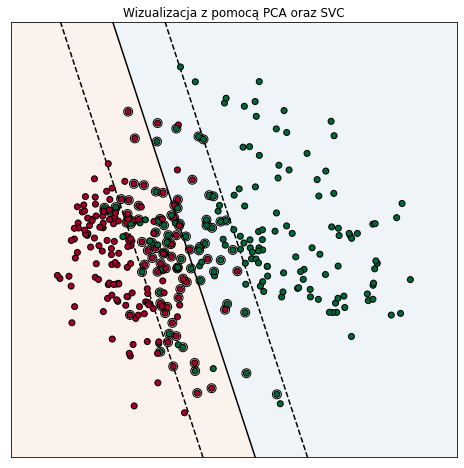

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

X, Y = tfidf_wm.toarray(), articles["label"]

X = PCA(2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

penalty = 5

clf = svm.SVC(kernel="linear", C=penalty)
clf.fit(x_train, y_train)

predicted = clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(clf.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.figure(1, figsize=(8, 8))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
    cmap=cm.get_cmap("RdYlGn"),
)
plt.scatter(
    X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap("RdYlGn"), edgecolors="k"
)

plt.axis("tight")
x_min = X[:, 0].min() - 0.1
x_max = X[:, 0].max() + 0.1
y_min = X[:, 1].min() - 0.1
y_max = X[:, 1].max() + 0.1

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)


plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.title('Wizualizacja z pomocą PCA oraz SVC')
plt.show()


### Key words

In [30]:
key_anti_words, key_pro_words = f_importances(sgdc_classifier.coef_,tfidf_tokens, limit=50)

pd.DataFrame(data={"PRO":[*zip(*key_pro_words)][1],"ANTI":[*zip(*key_anti_words)][1]},index=range(1,51))


PRO          ANTI
1               barré        injury
2          vaccinated        report
3               safer      tinnitus
4              worker       adverse
5                cell          mass
6          protection         dobbs
7             getting     injection
8   immunocompromised    government
9          additional    ivermectin
10             oxford       mandate
11               horo         wuhan
12              might           jab
13            omicron         death
14                 le          kill
15          candidate    lymphocyte
16     seroconversion         wrote
17                two        israel
18          volunteer        medium
19           clinical        vanden
20           illinois       article
21         restaurant          hour
22             travel         fauci
23           biontech    autoimmune
24            protect         pilot
25           infected           lie
26         monitoring       bossche
27               rare       natural
28           approval         ulcer
29            placebo         batch
30             morris       fraiman
31               side       product
32            booster          lied
33              lower  experimental
34             people    harrington
35             chance         paper
36            corbett         fraud
37        participant         biden
38            moderna        doctor
39             safety         snake
40            antigen        innate
41               dose      immunity
42            sarscov         order
43           efficacy       marburg
44          effective          dore
45                dos           aid
46               part      evidence
47               risk           joe
48              trial        patent
49                get  depopulation
50            vaccine        native

### Article vectors

In [31]:
key_words = [s for _,s in key_pro_words+key_anti_words]
article_vectors = []

for a in words_pa:
    zliczone = Counter([word for word in a if word in key_words])
    article_vectors.append([zliczone[s] for s in key_words])

article_vectors = TfidfTransformer().fit_transform(article_vectors)
article_vectors = article_vectors.toarray()

[[31  7]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        38
           1       0.81      1.00      0.90        30

    accuracy                           0.90        68
   macro avg       0.91      0.91      0.90        68
weighted avg       0.92      0.90      0.90        68



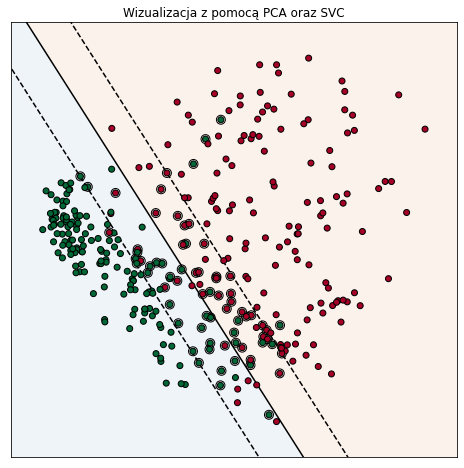

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

X, Y = article_vectors, articles["label"]

X = PCA(2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

penalty = 5

clf = svm.SVC(kernel="linear", C=penalty)
clf.fit(x_train, y_train)

predicted = clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(clf.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.figure(1, figsize=(8, 8))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
    cmap=cm.get_cmap("RdYlGn"),
)
x_min = X[:, 0].min() - 0.1
x_max = X[:, 0].max() + 0.1
y_min = X[:, 1].min() - 0.1
y_max = X[:, 1].max() + 0.1

plt.scatter(
    X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap("RdYlGn"), edgecolors="k"
)

plt.axis("tight")

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)


plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.title('Wizualizacja z pomocą PCA oraz SVC')
plt.show()


 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.39665042824569424


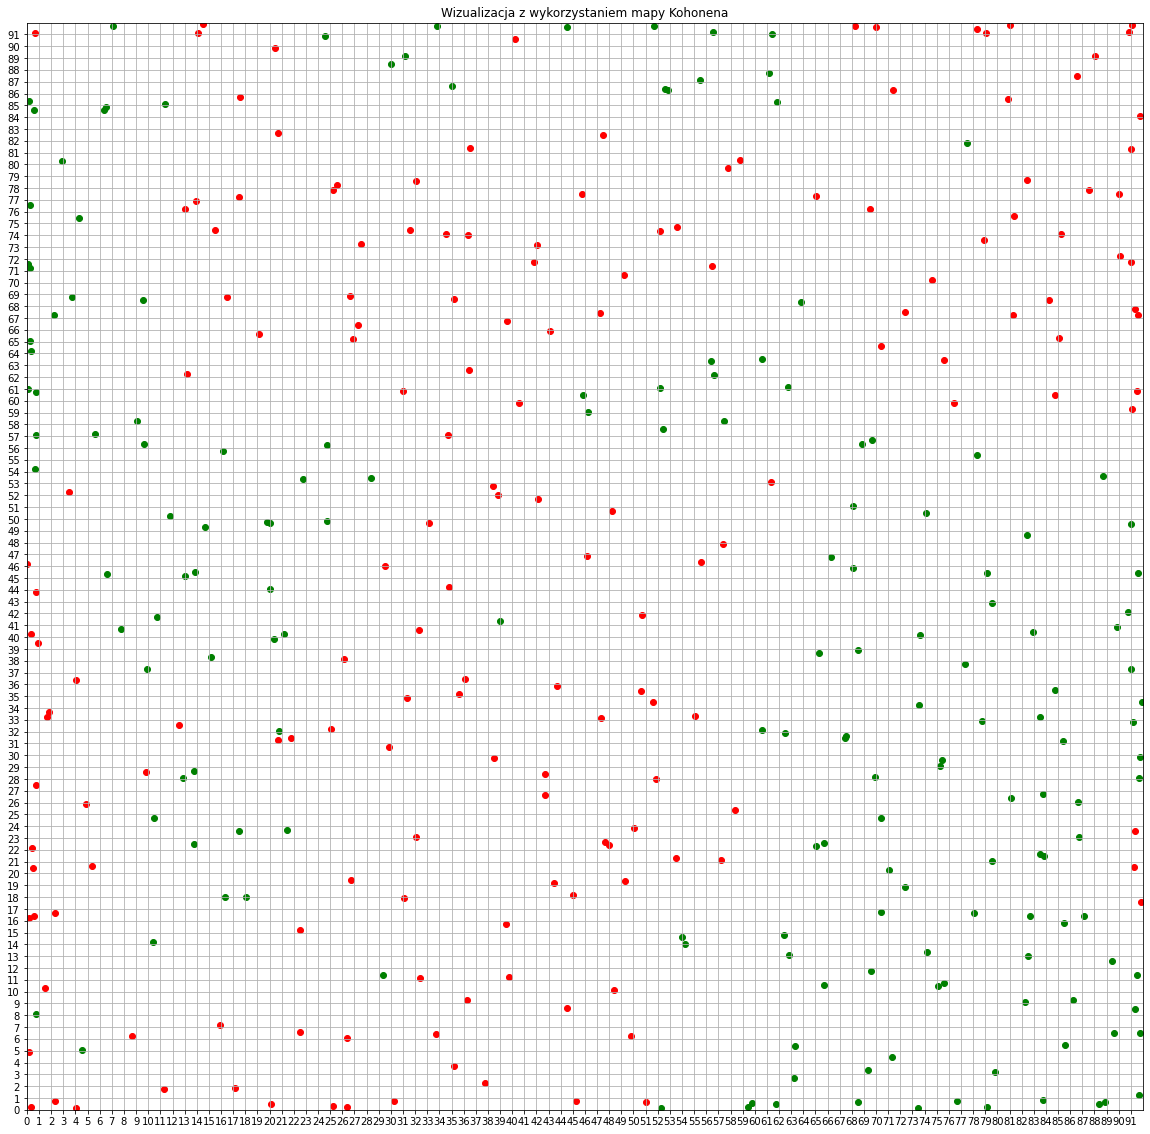

In [33]:
N = int(5*np.sqrt(len(article_vectors)))
som = MiniSom(N,N,len(key_words),sigma=8, learning_rate=0.25, activation_distance='cosine')

som.random_weights_init(article_vectors)
som.train_random(article_vectors,2000,verbose=True)

x = plt.figure(figsize=(20, 20))

for _, (c, vec) in enumerate(zip(['r' if label==0 else 'g' for label in articles["label"]], article_vectors)):
    winnin_position = som.winner(vec)
    plt.scatter(winnin_position[0]+np.random.rand()*.9, winnin_position[1]+np.random.rand()*.9,color=c)
plt.xticks(range(N))
plt.yticks(range(N))
plt.grid()
plt.title("Wizualizacja z wykorzystaniem mapy Kohonena")
plt.xlim([0, N])
plt.ylim([0, N])
plt.plot()
plt.show()
plt.close(x)

### Simulation

In [34]:
key_words = [s for _,s in key_pro_words + key_anti_words]
close_words = find_close_words(words_pa,key_words)
pro_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==1]
anti_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==0]
vector_colors = ['r' if i>len(key_pro_words) else 'g' for i,_ in enumerate(key_words)]

sigma = 8
learning_rate = 0.5
size = int(5*np.sqrt(len(key_words)))

anti_knowledge_data,_ = random_percent(anti_words_pa,0.8)
pro_knowledge_data,_ = random_percent(pro_words_pa,0.8)
all_knowledge_data_1, anti_read_data = random_percent(anti_words_pa,0.5*0.8)
all_knowledge_data_2, pro_read_data = random_percent(pro_words_pa,0.5*0.8)

all_knowledge_data = all_knowledge_data_1 + all_knowledge_data_2

In [35]:
def read_data(who: MiniSom, what: list, learning_rate, title=''):
    fig, plots = plt.subplots(1, 1,figsize=(20,20))
    new = MiniSom(*who.get_weights().shape,sigma=16,learning_rate=learning_rate,activation_distance='cosine')
    new._weights = deepcopy(who.get_weights())

    new.train(what,200,verbose=True)

    plot_vectors(plots,new,what,vector_colors,key_words,who.get_weights().shape[0],title)

    plt.show()
    plt.close(fig)

In [36]:
def tfidf_vectors(data):
    vectors = generate_vectors(prepare_dictionary(data,key_words,r=2),close_words)
    return TfidfTransformer().fit_transform(list(vectors.values())).toarray()

def new_simulation(who,what,title):
    vectors = tfidf_vectors(what)
    for n in [1,0.5,0.25,0.15,0.1,0.05,0.01]:
        read_data(who,vectors,n,
                  title=f'{title} dla learning rate = {n}')

def knowledge_init(som,knowledge,title=''):
    fig, plot = plt.subplots(1, 1,figsize=(20,20))
    vectors = tfidf_vectors(knowledge)
    som.train(vectors,300,verbose=True)

    plot_vectors(plot,som,vectors,vector_colors,key_words,som.get_weights().shape[0],title)

    plt.show()
    plt.close(fig)

In [37]:
anti_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')
pro_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')
all_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')

 [ 300 / 300 ] 100% - 0:00:00 left 
 quantization error: 0.6554049706784711


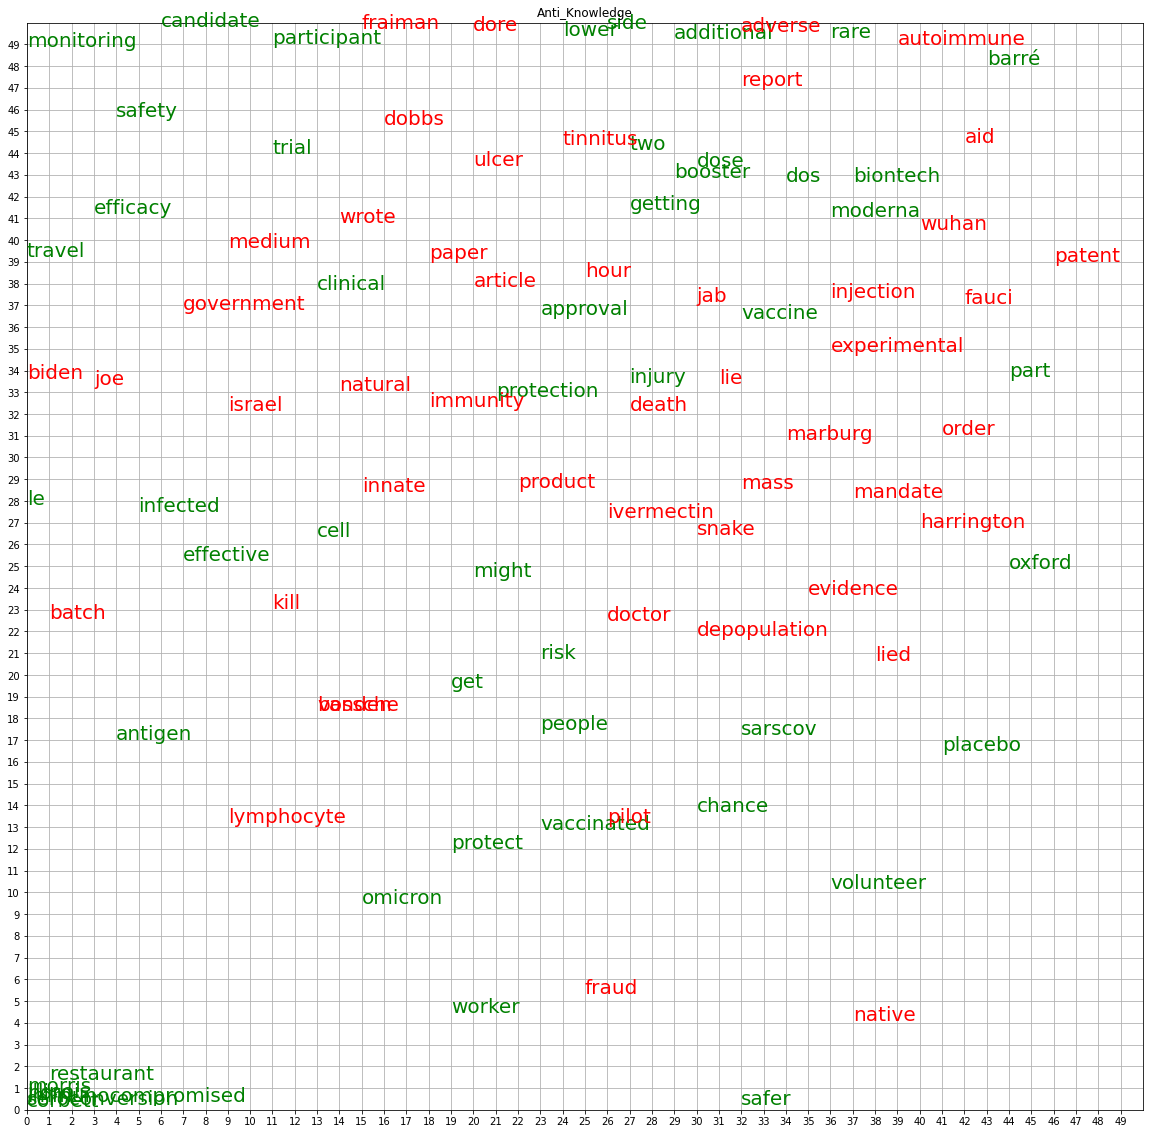

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.800807546571361


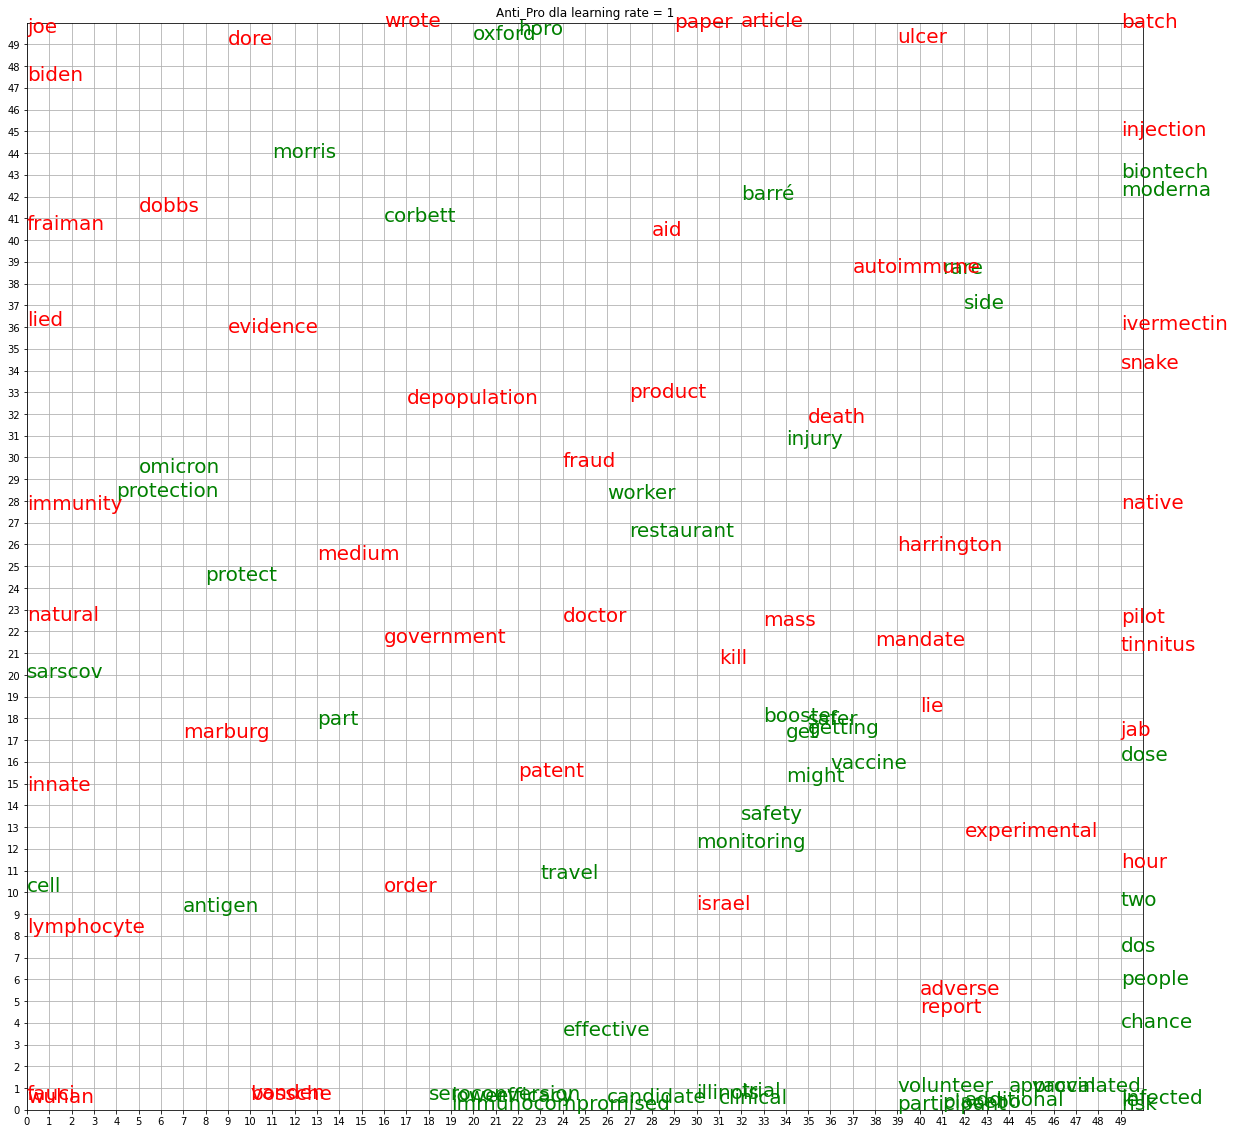

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8279855961745953


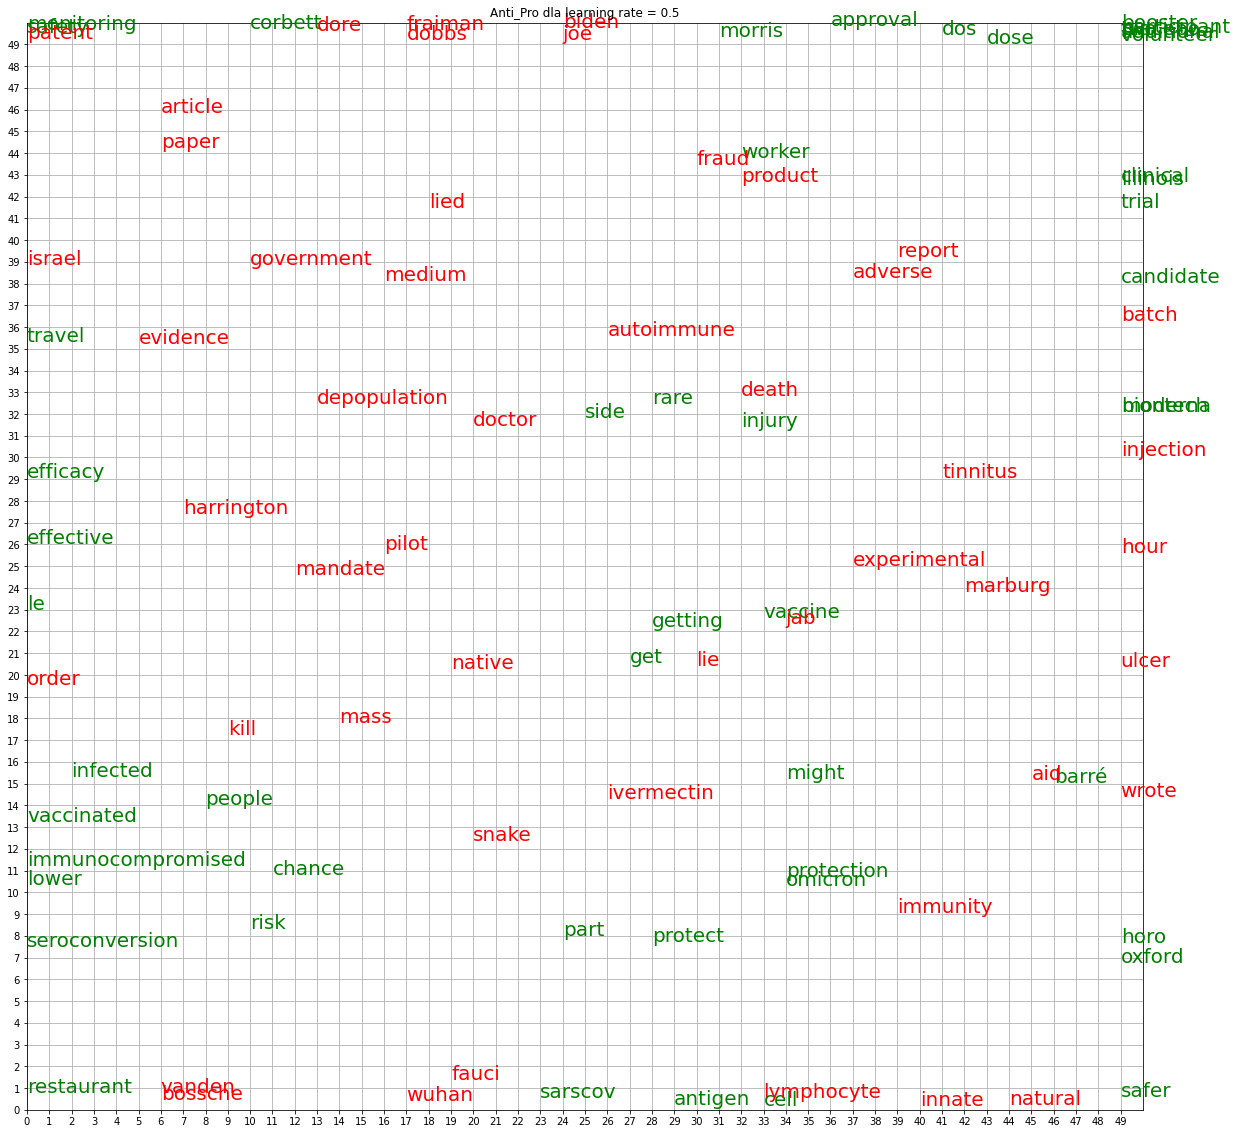

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.854657878440034


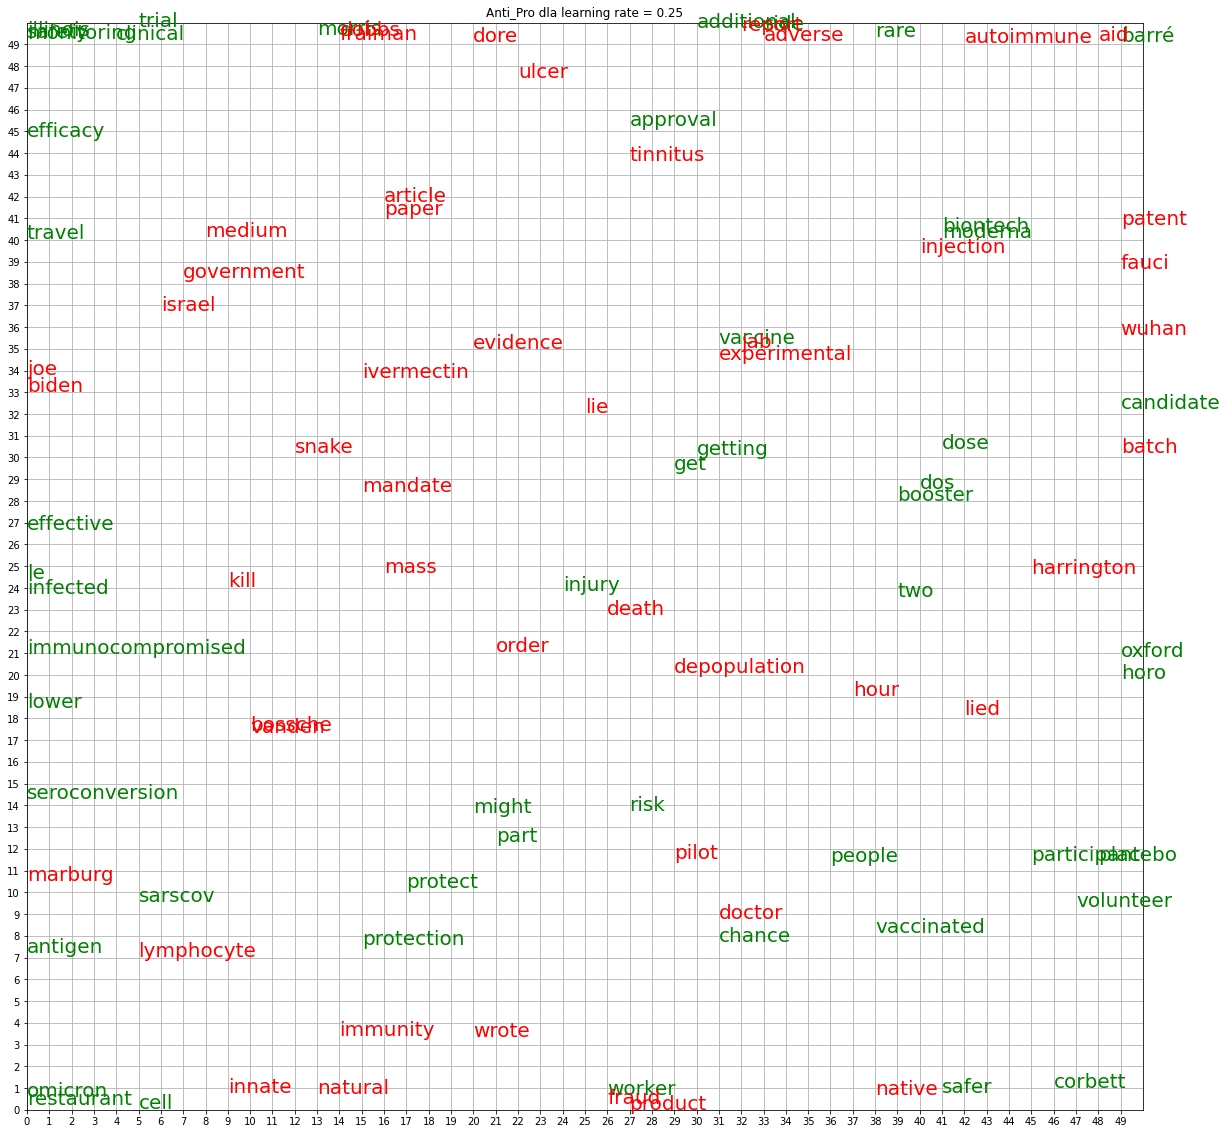

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8752077434872578


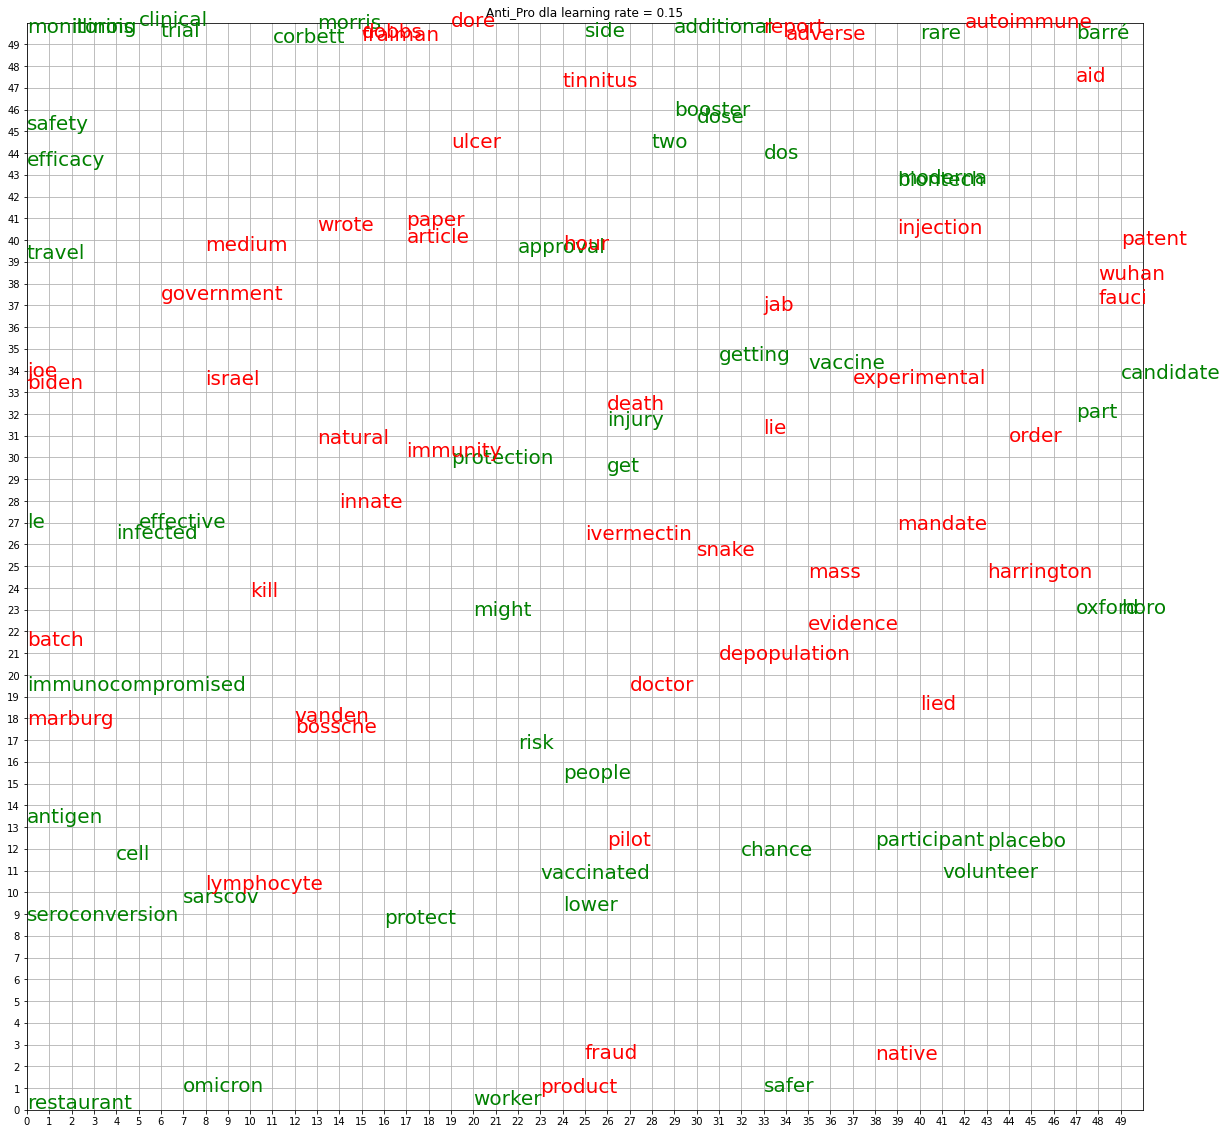

 [ 200 / 200 ] 100% - 0:00:01 left 
 quantization error: 0.8781994153793611


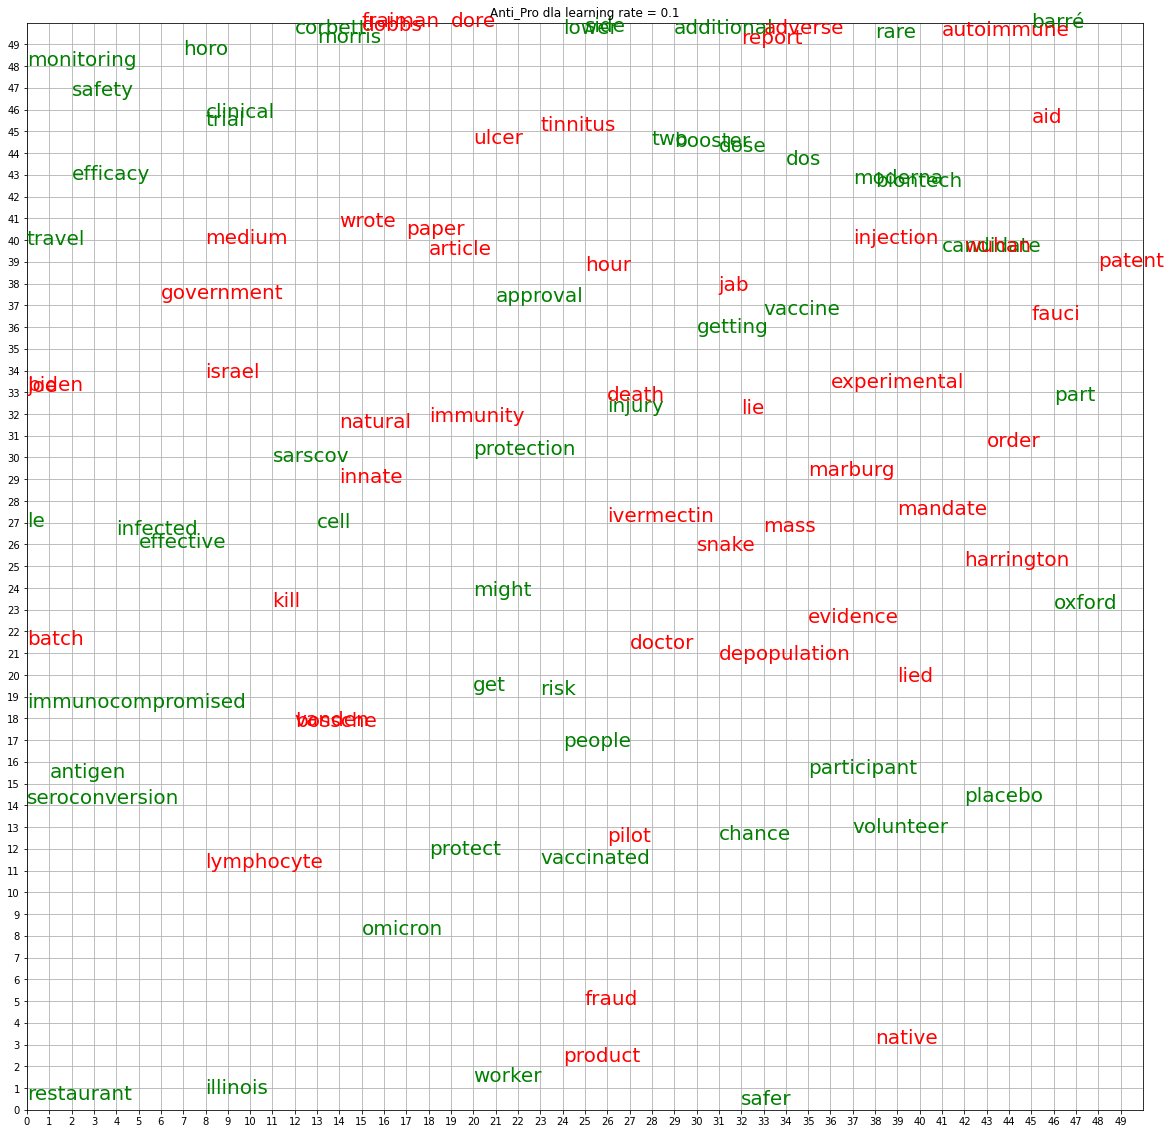

 [ 200 / 200 ] 100% - 0:00:01 left 
 quantization error: 0.857360188210664


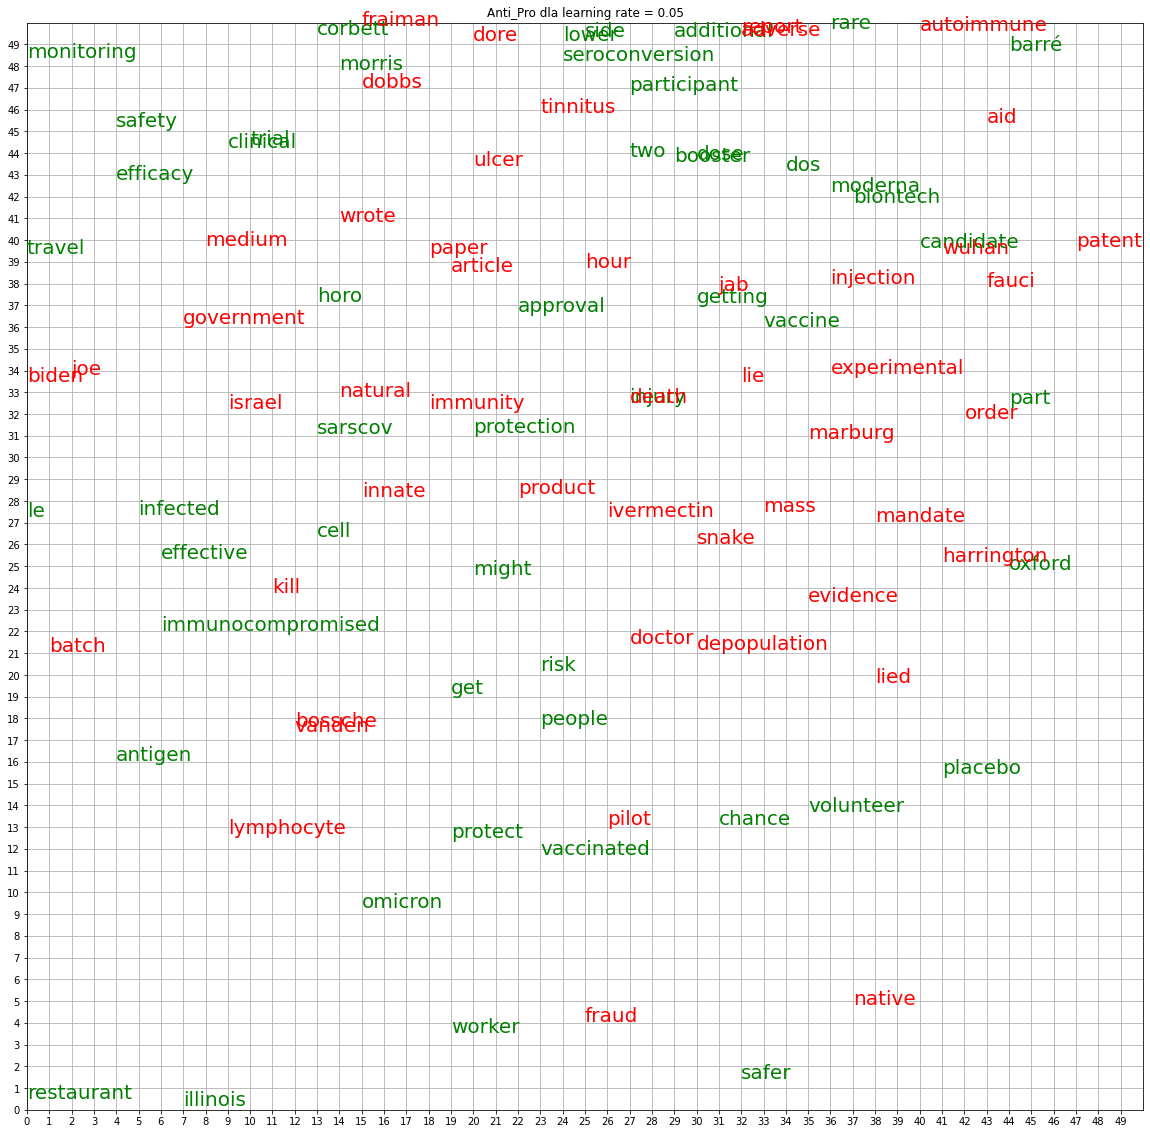

 [ 200 / 200 ] 100% - 0:00:01 left 
 quantization error: 0.798257148540213


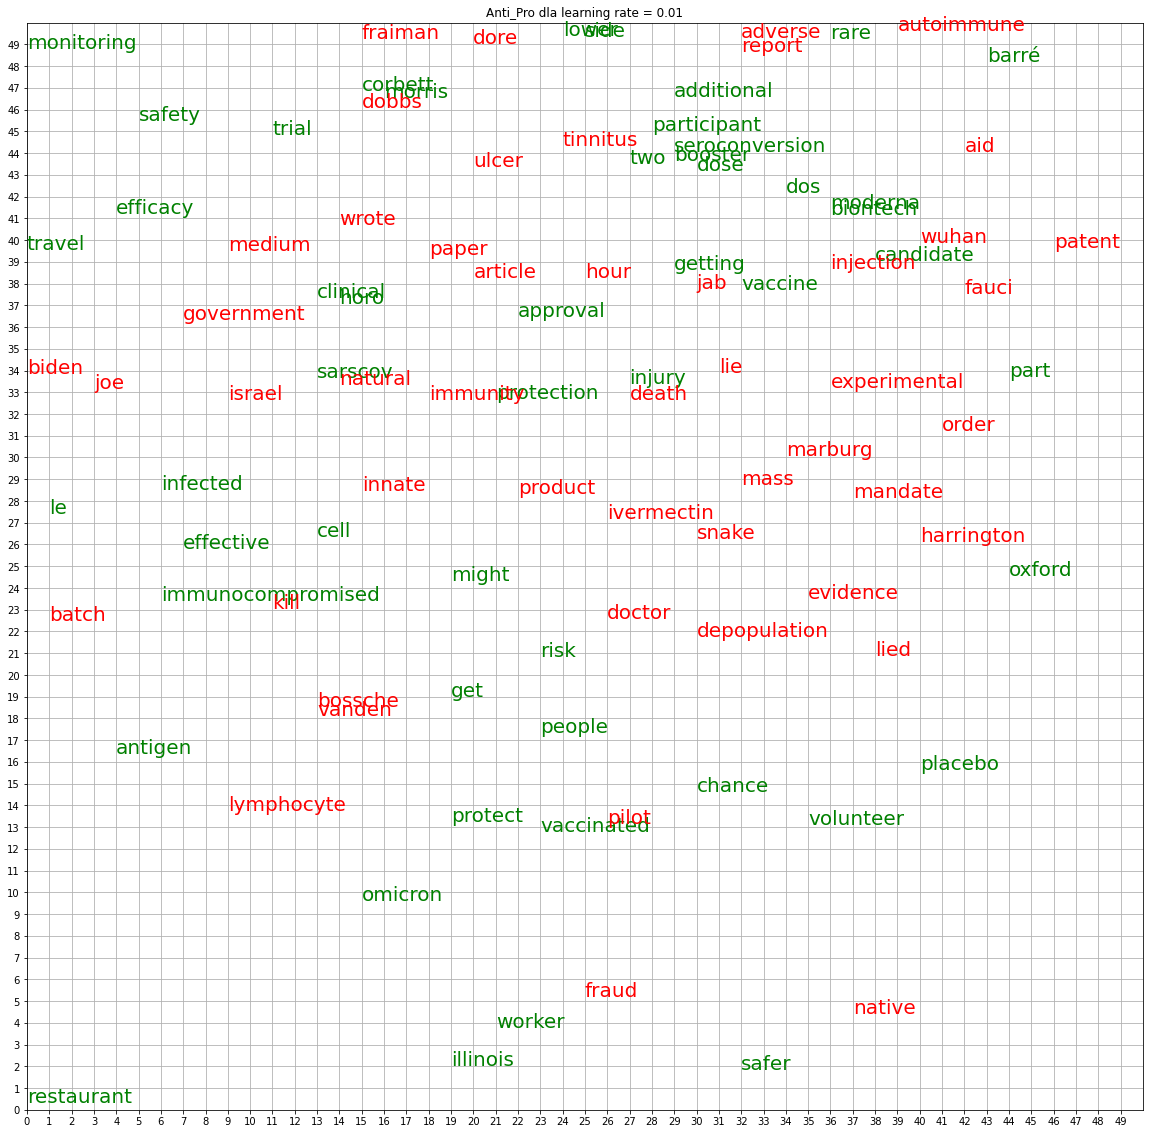

In [38]:
knowledge_init(anti_person,anti_words_pa,"Anti_Knowledge")
to_read,_ = random_percent(pro_words_pa,0.8)
new_simulation(anti_person,anti_words_pa+to_read,"Anti_Pro")

 [ 300 / 300 ] 100% - 0:00:01 left 
 quantization error: 0.5785671727166387


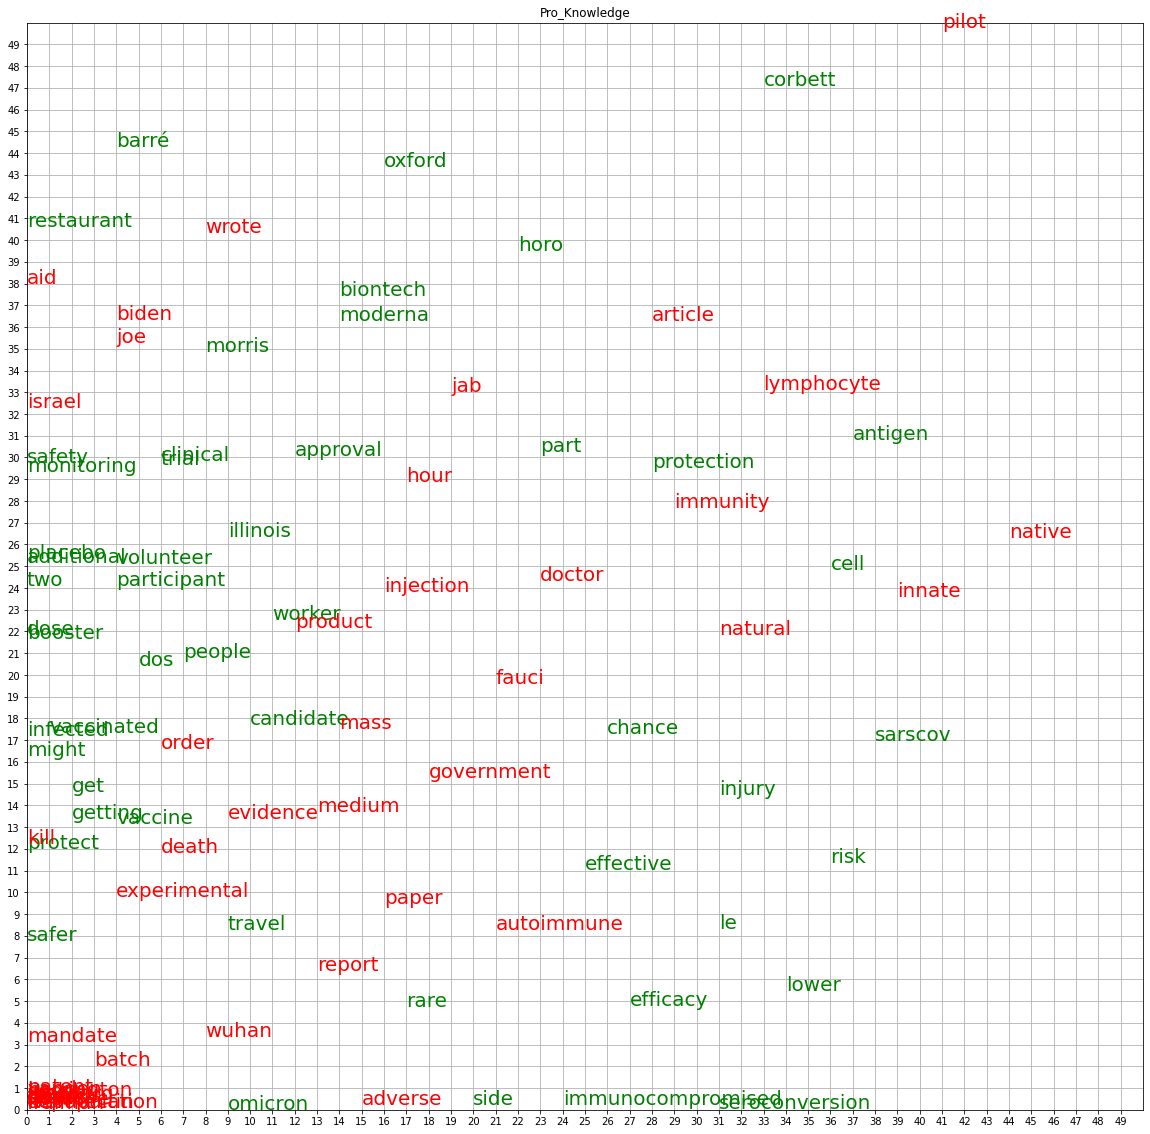

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8034262529381937


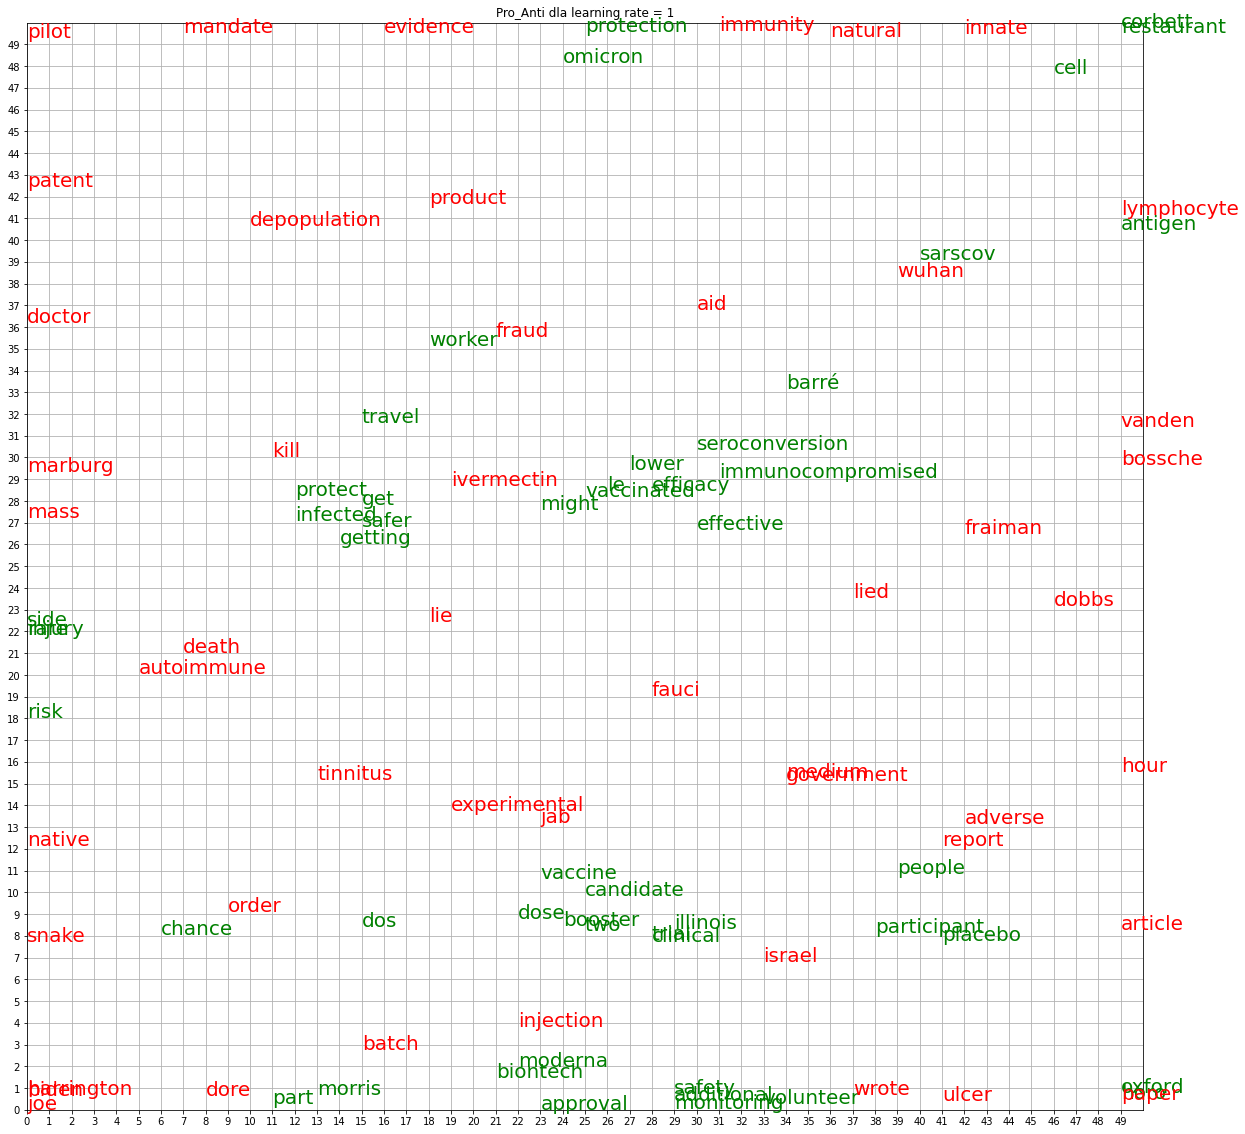

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8225505431236054


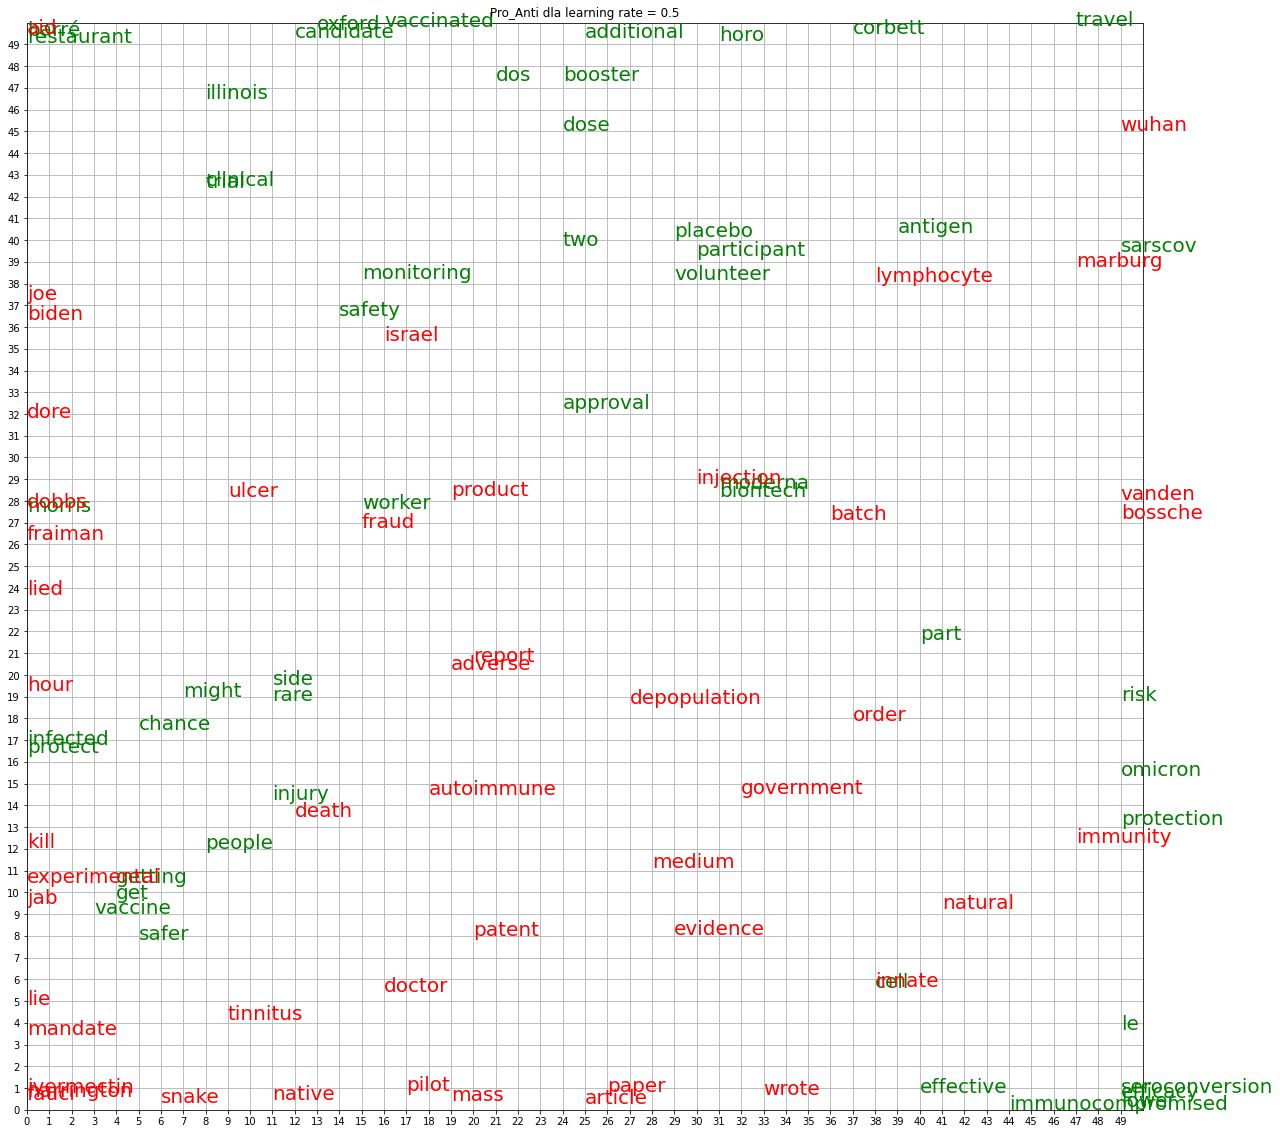

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8526754655136726


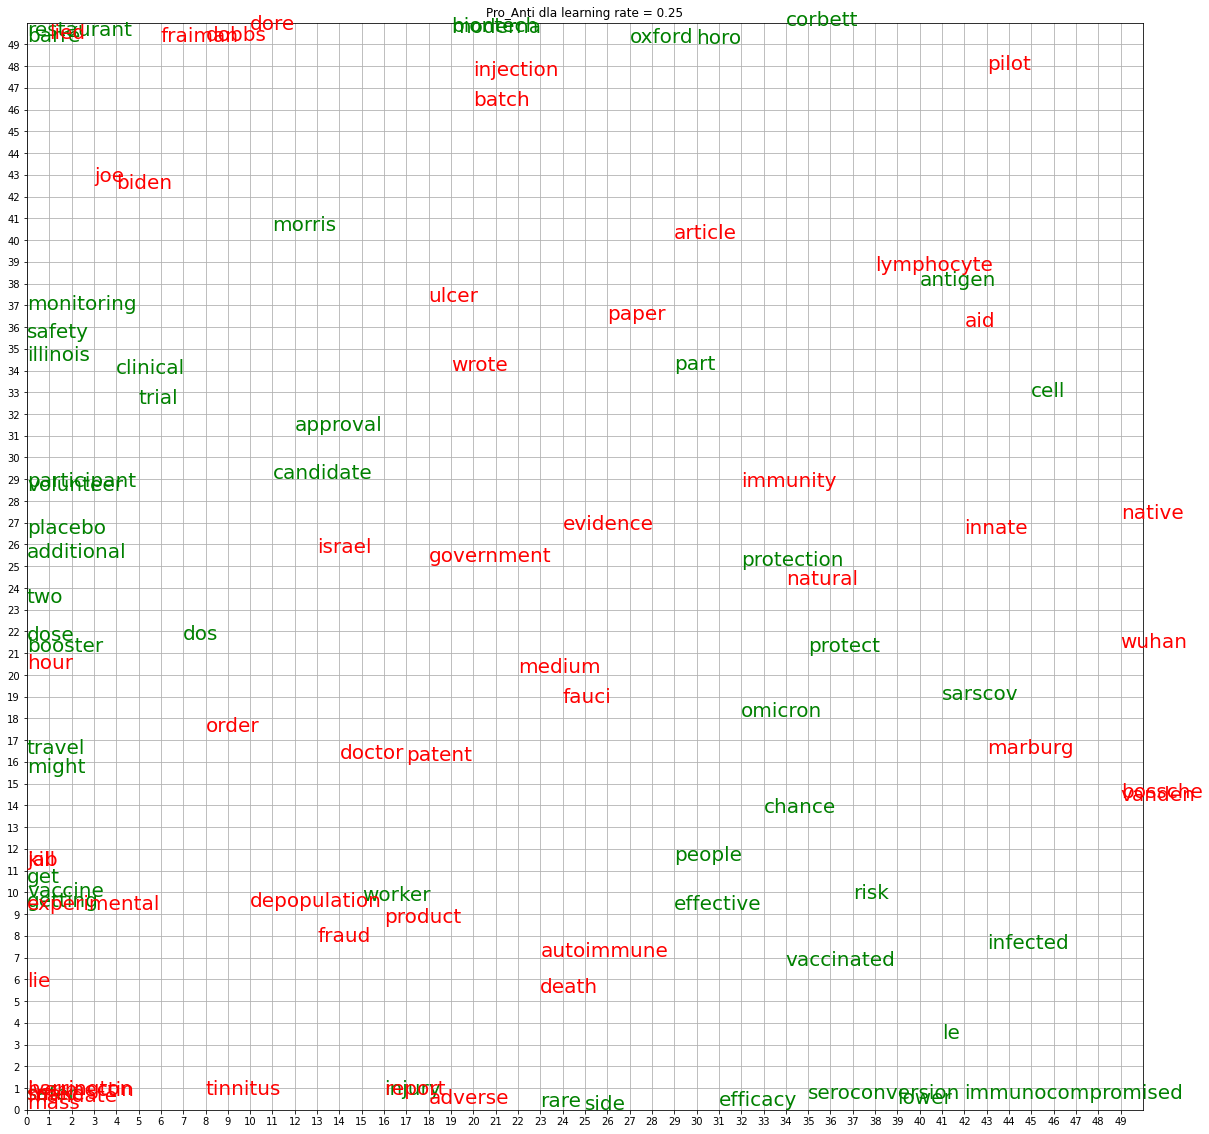

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8688743746780326


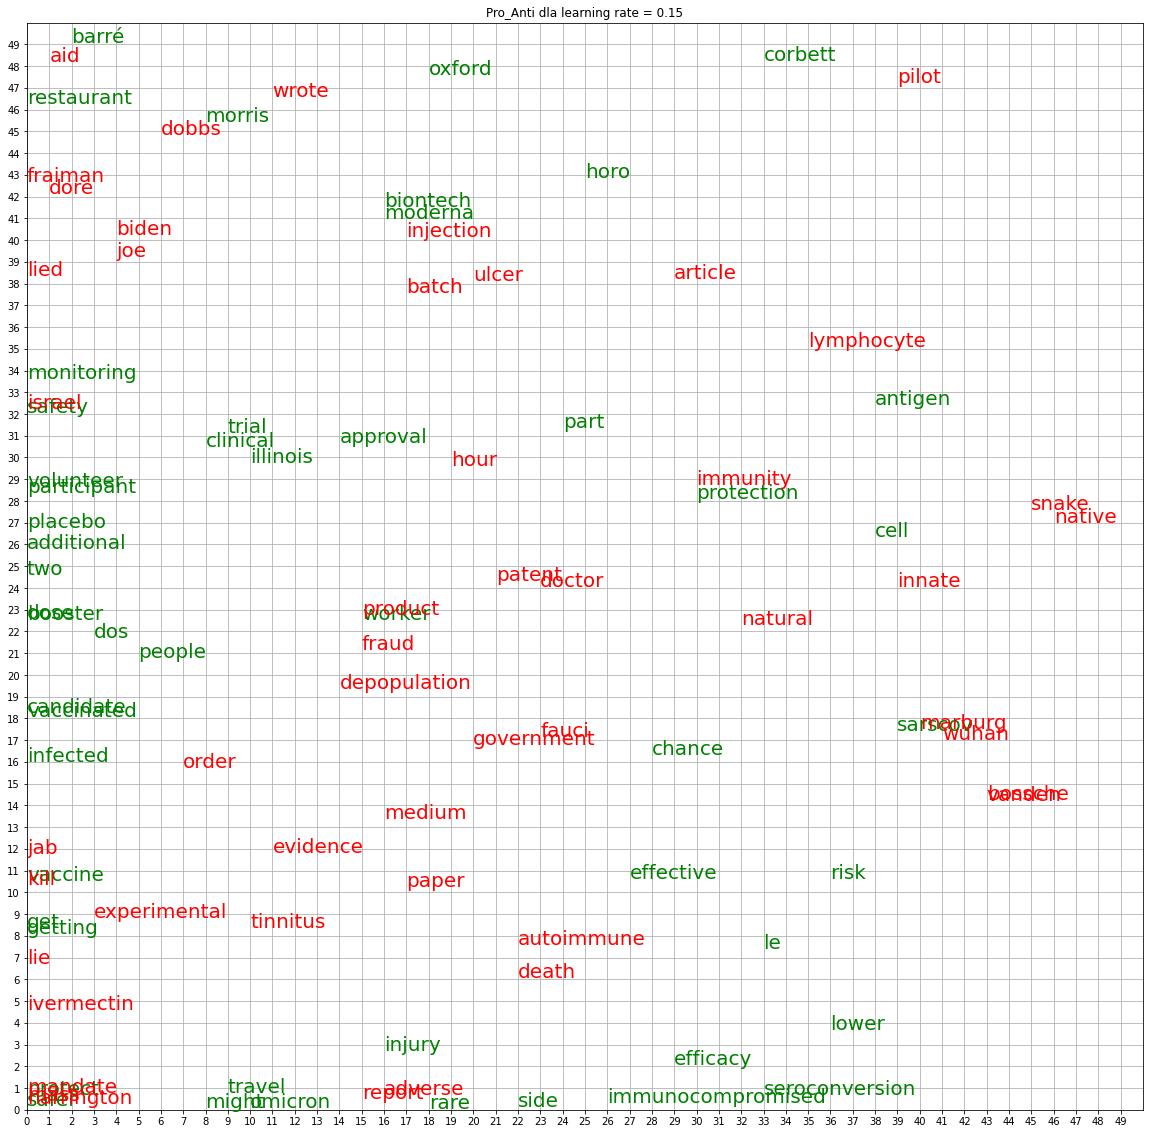

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8717850749459127


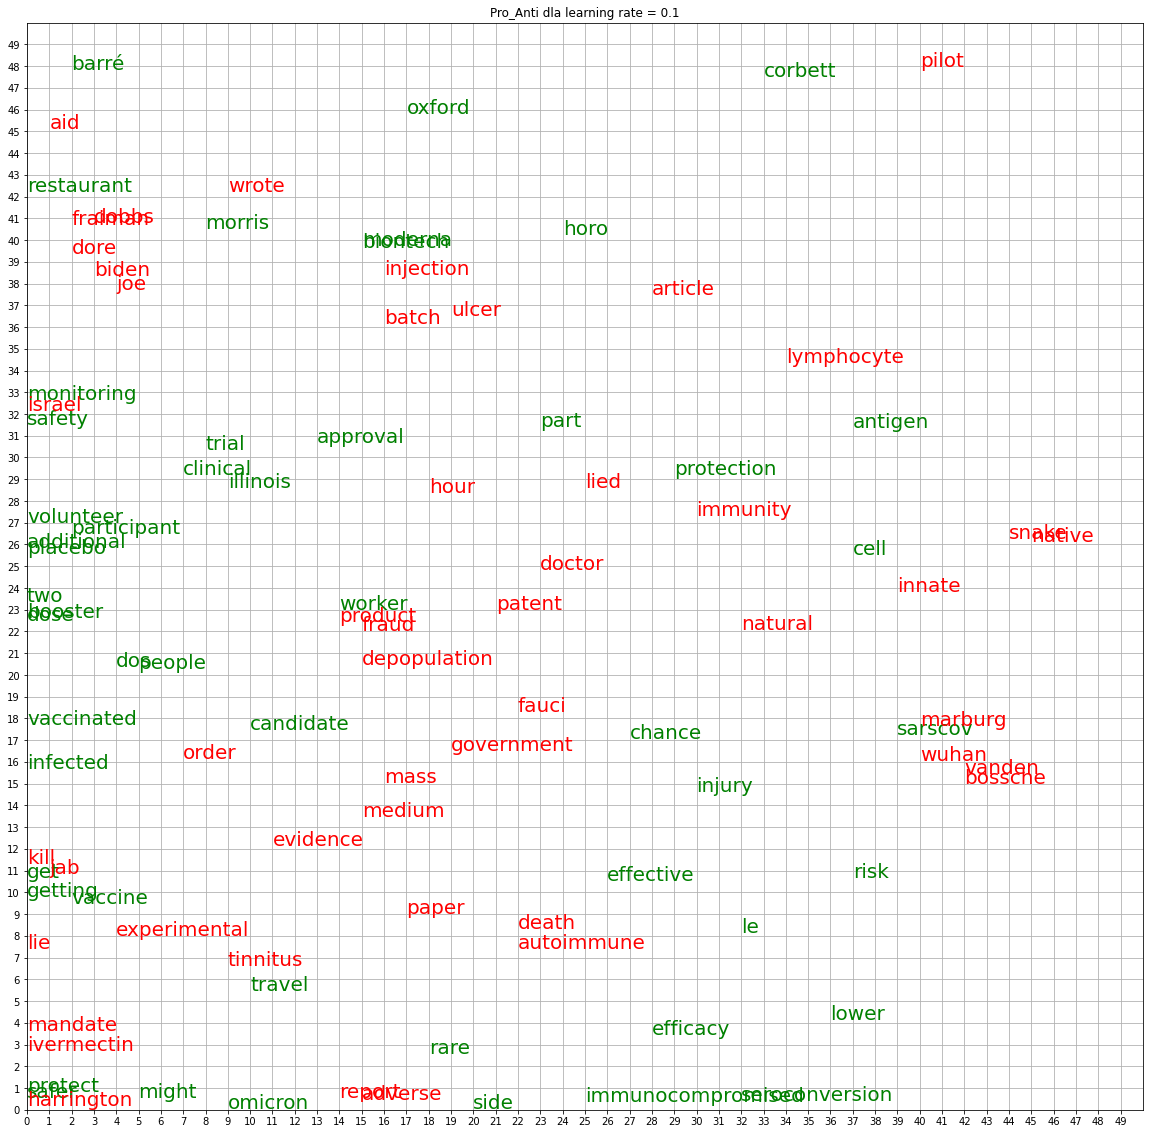

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8571341740010093


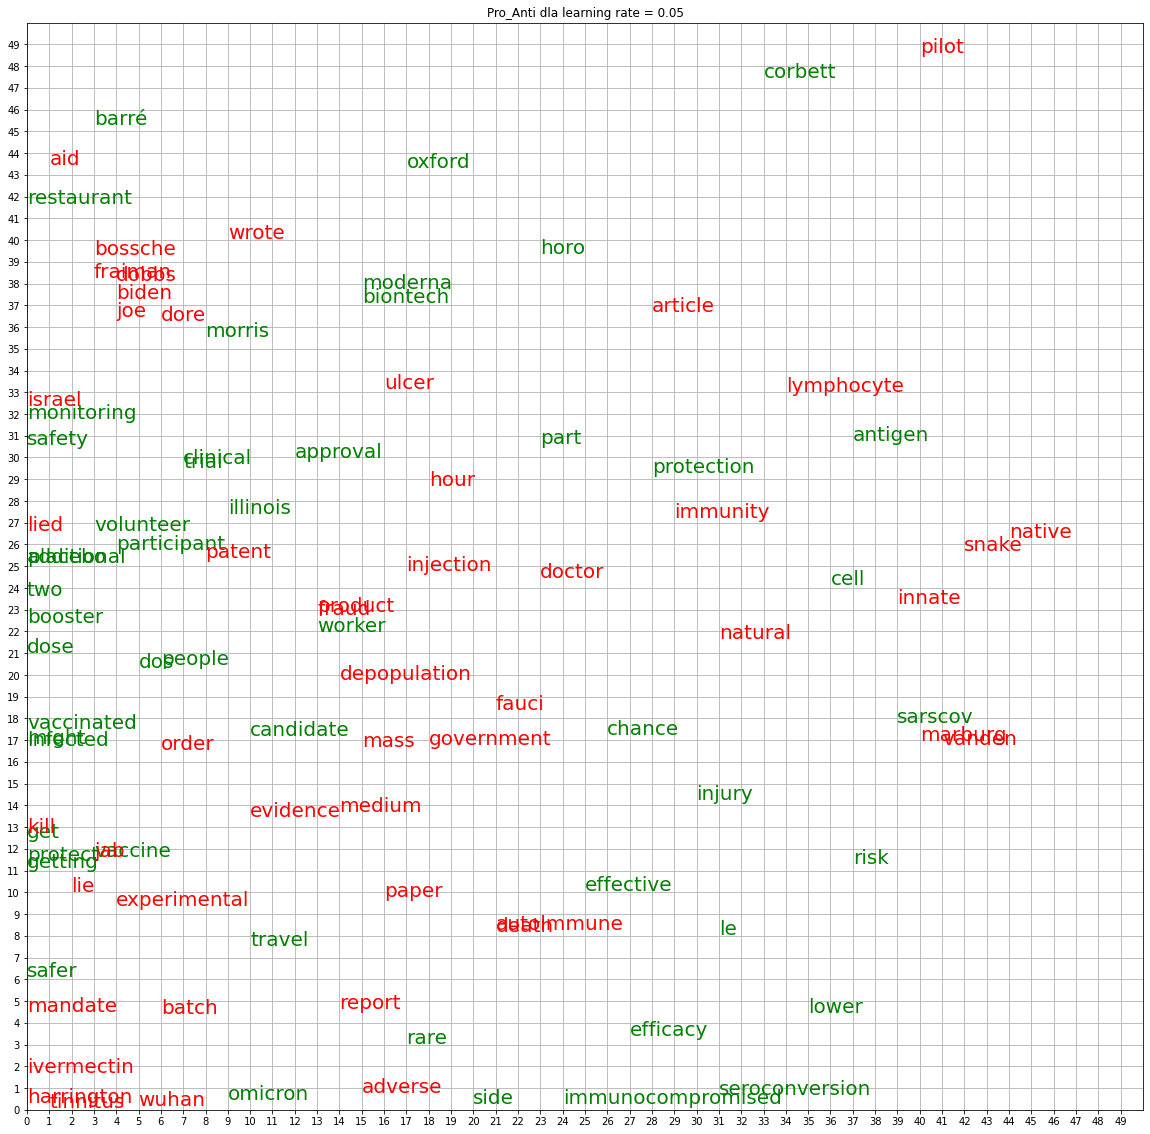

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.809858932724009


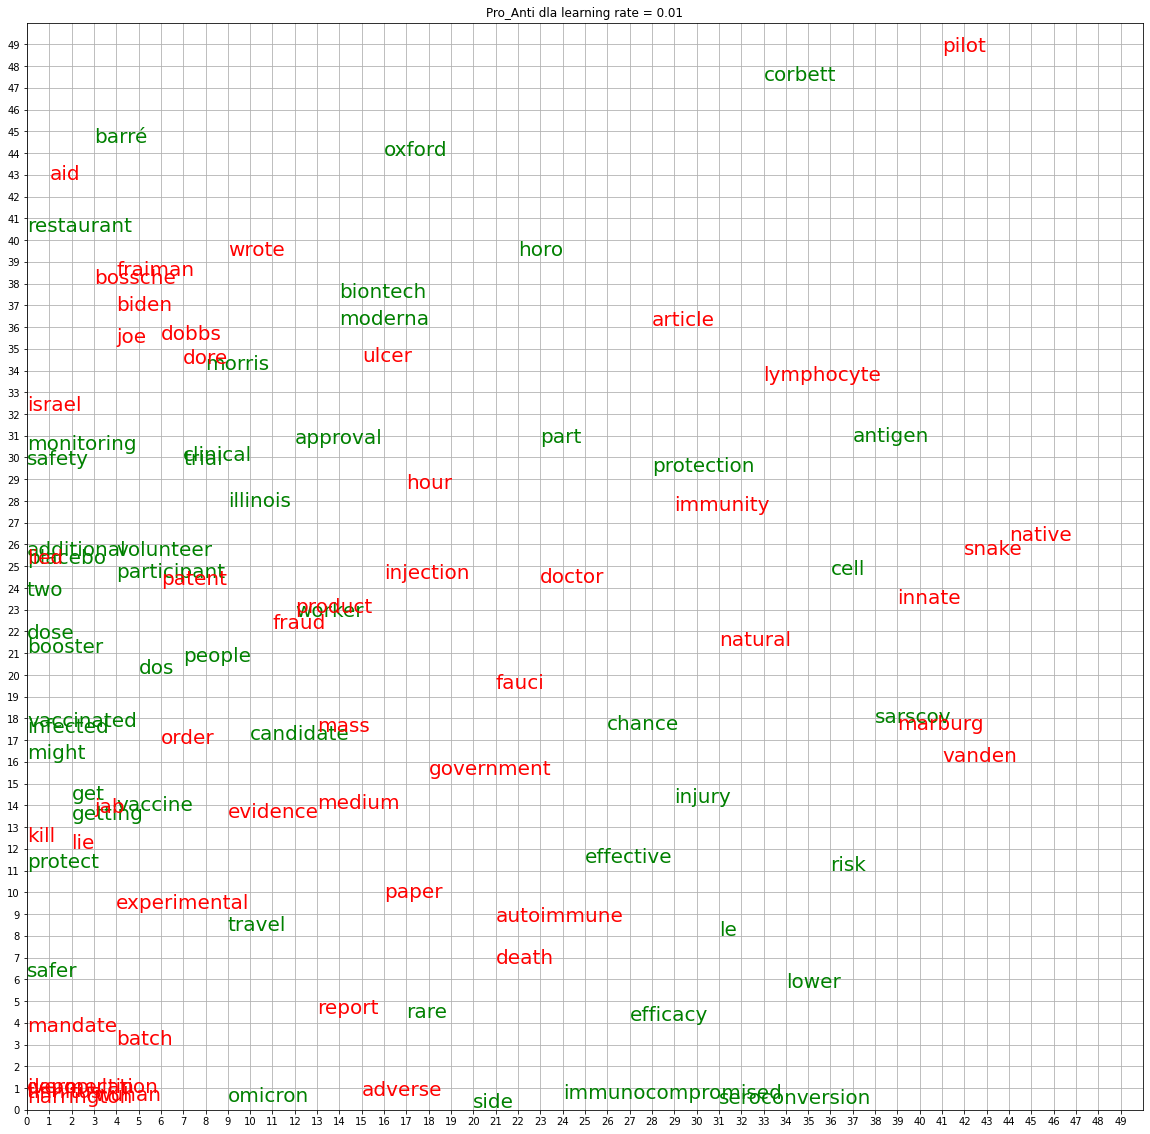

In [39]:
knowledge_init(pro_person,pro_words_pa,"Pro_Knowledge")
to_read,_ = random_percent(anti_words_pa,0.8)
new_simulation(pro_person,pro_words_pa+to_read,"Pro_Anti")

 [ 300 / 300 ] 100% - 0:00:00 left 
 quantization error: 0.6490174208496571


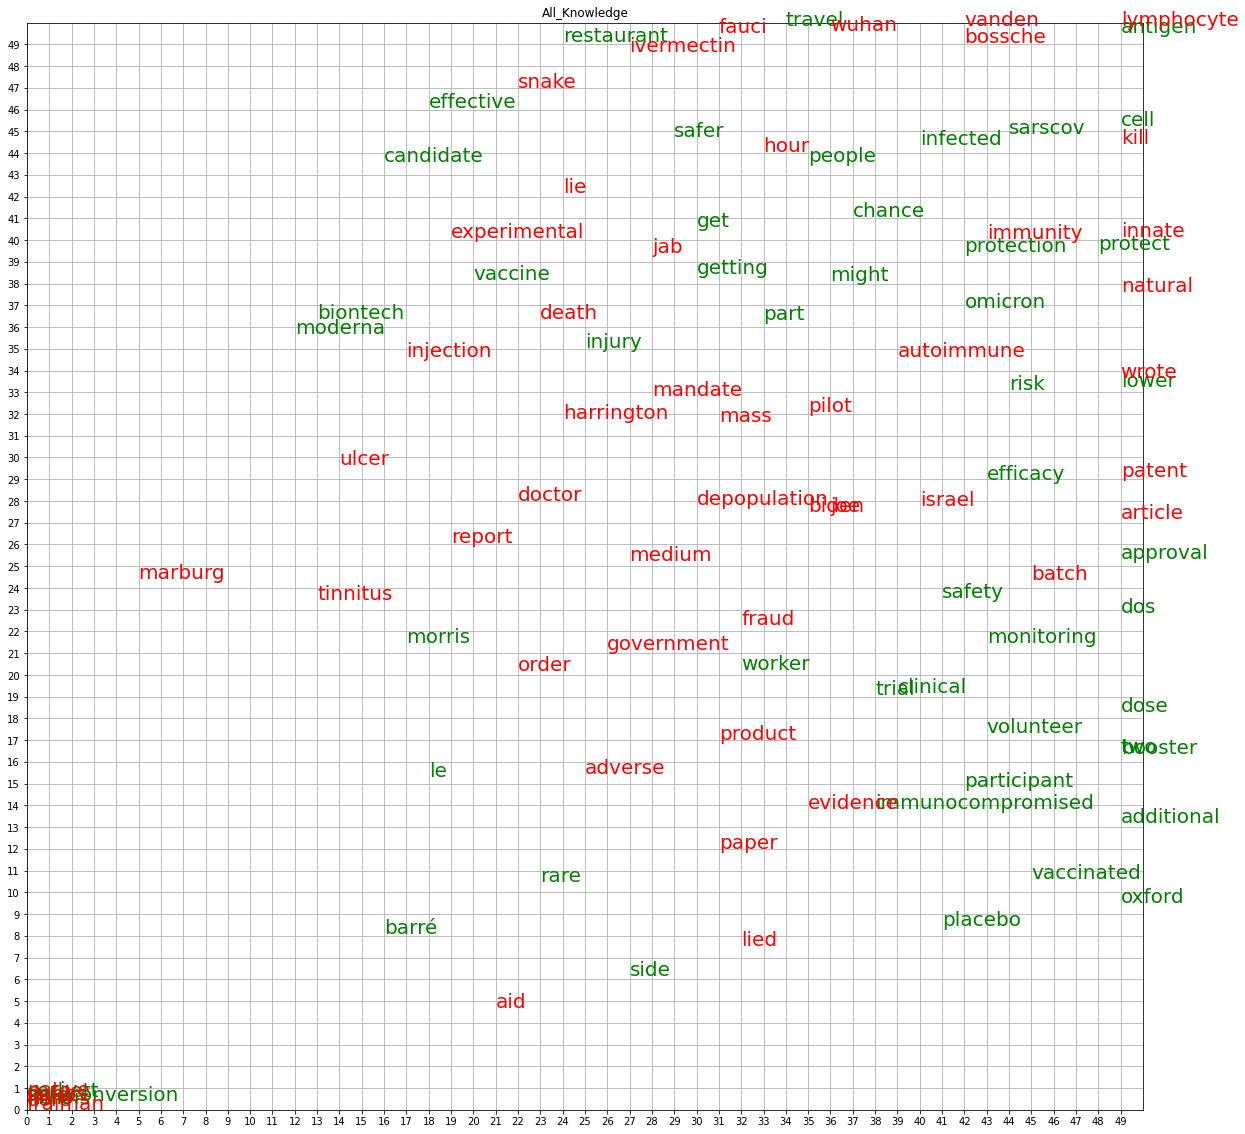

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.782599982869975


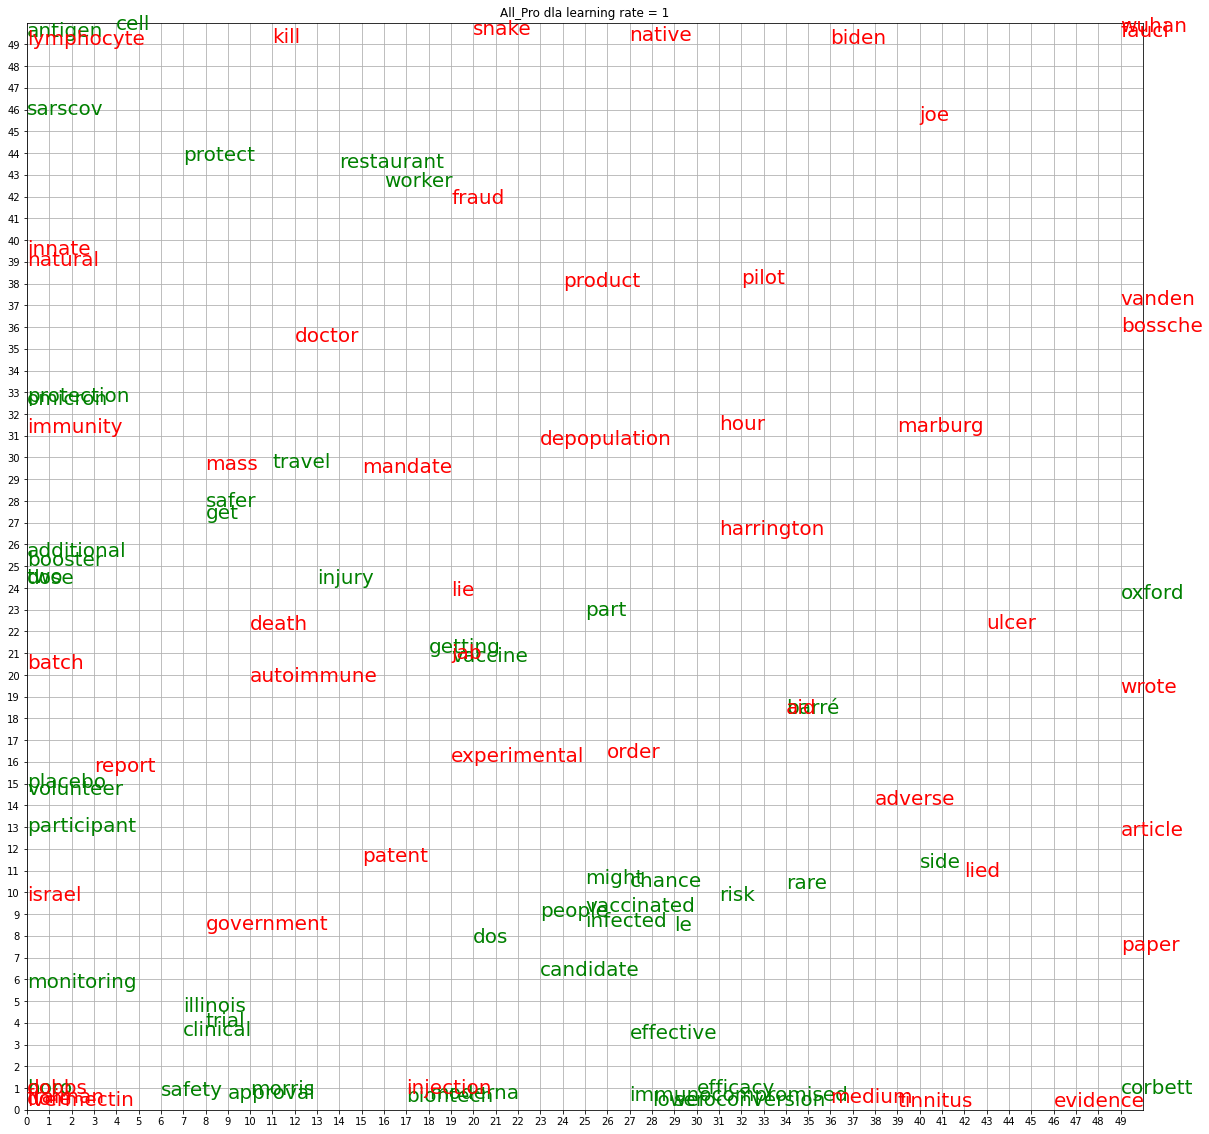

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8052148400230401


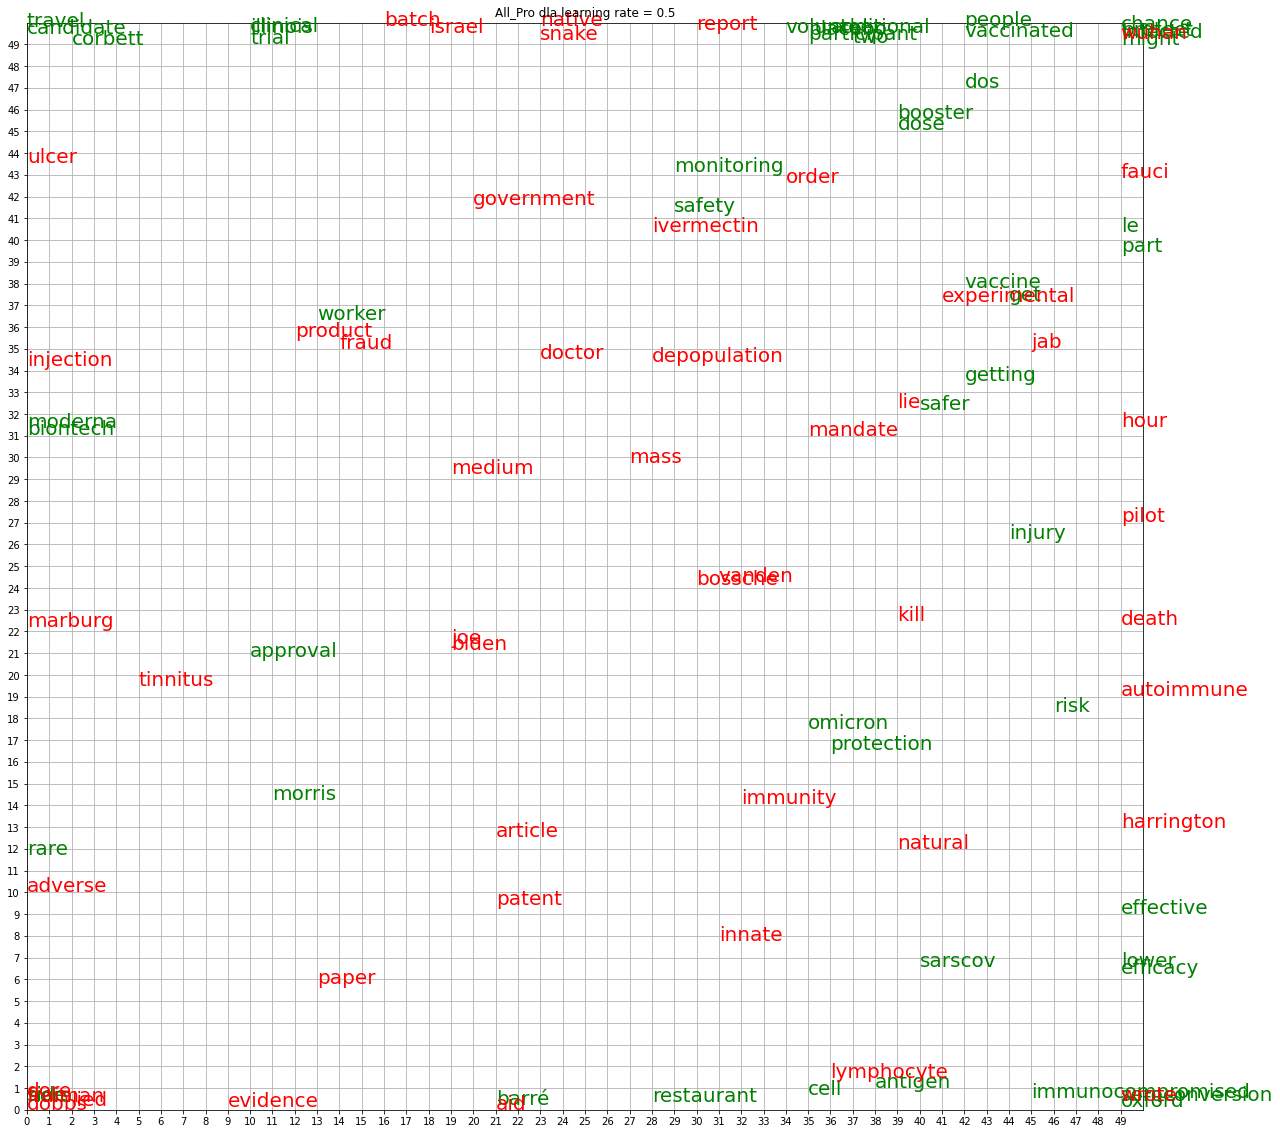

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8298388209853995


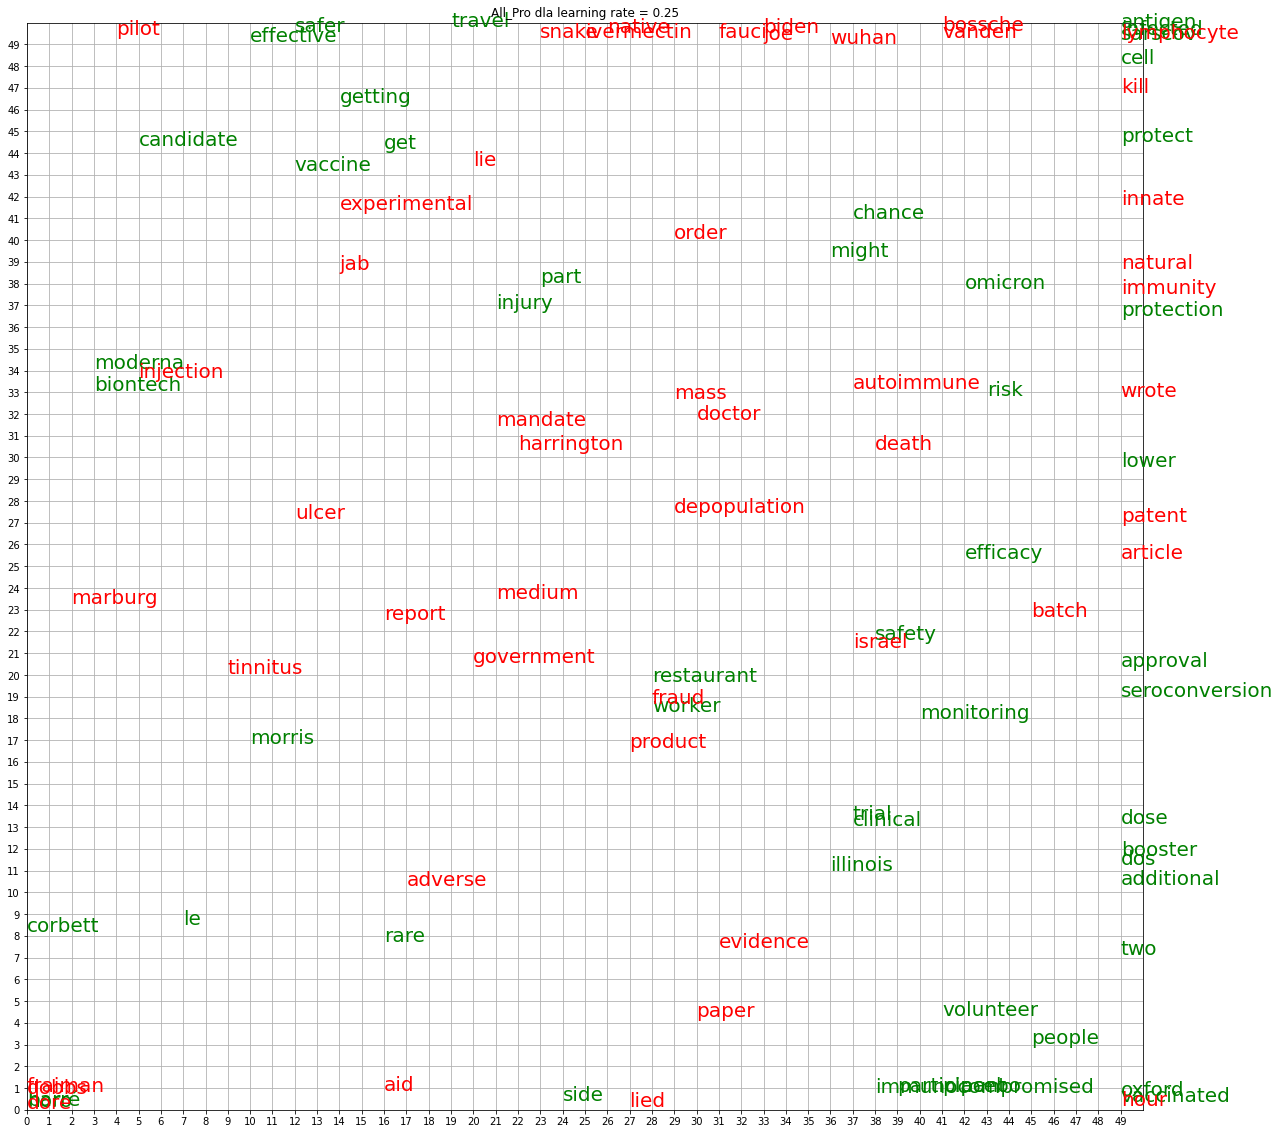

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8474285213366136


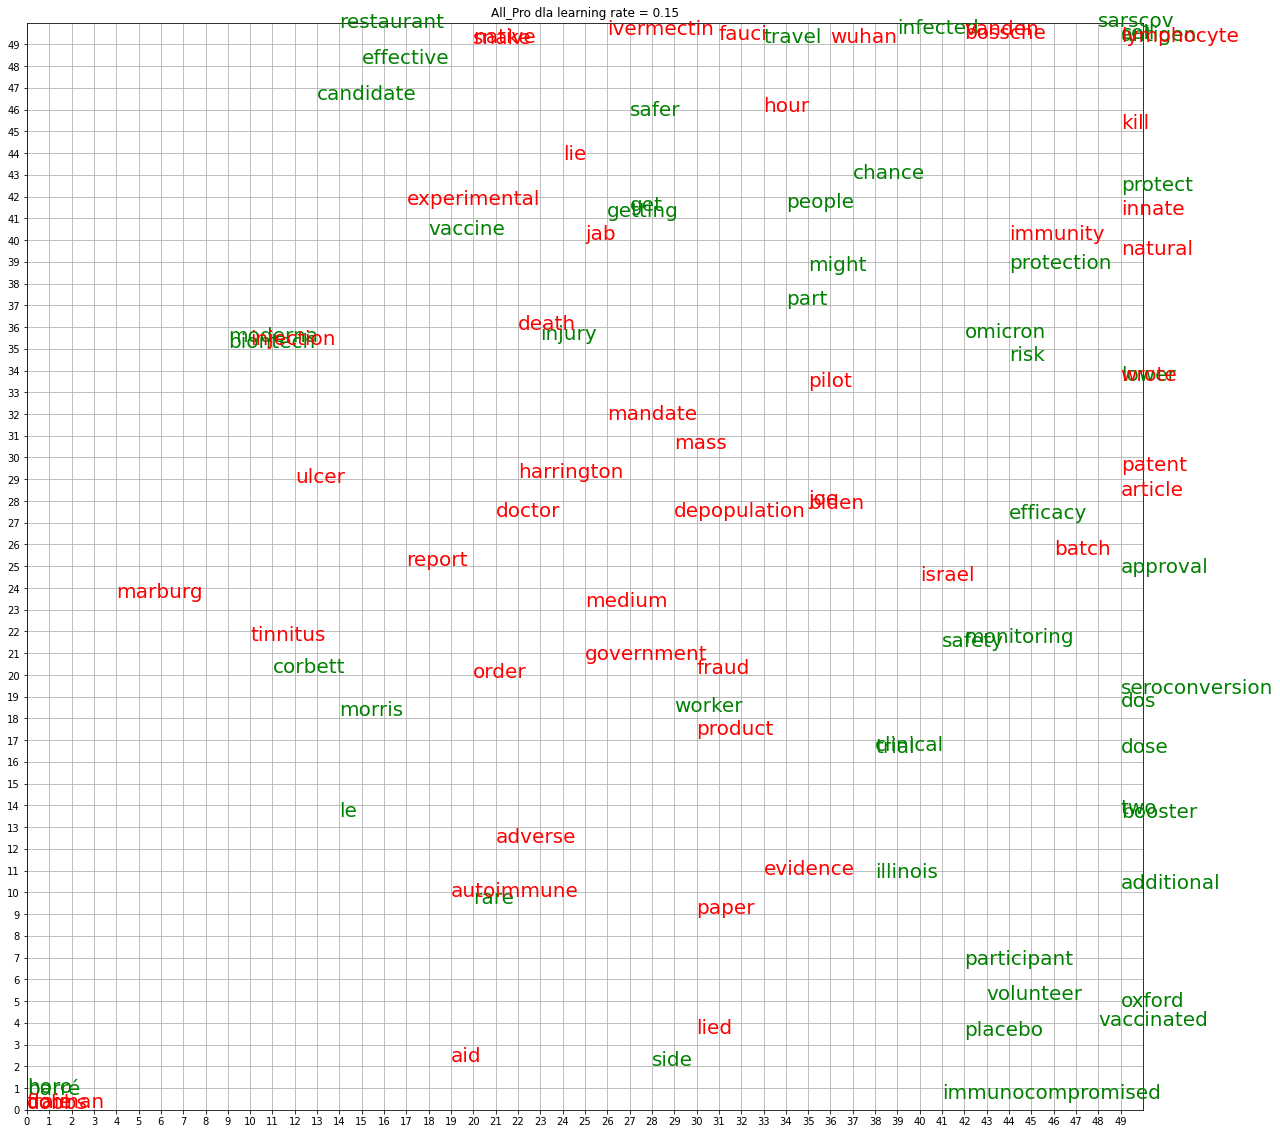

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8447083919822848


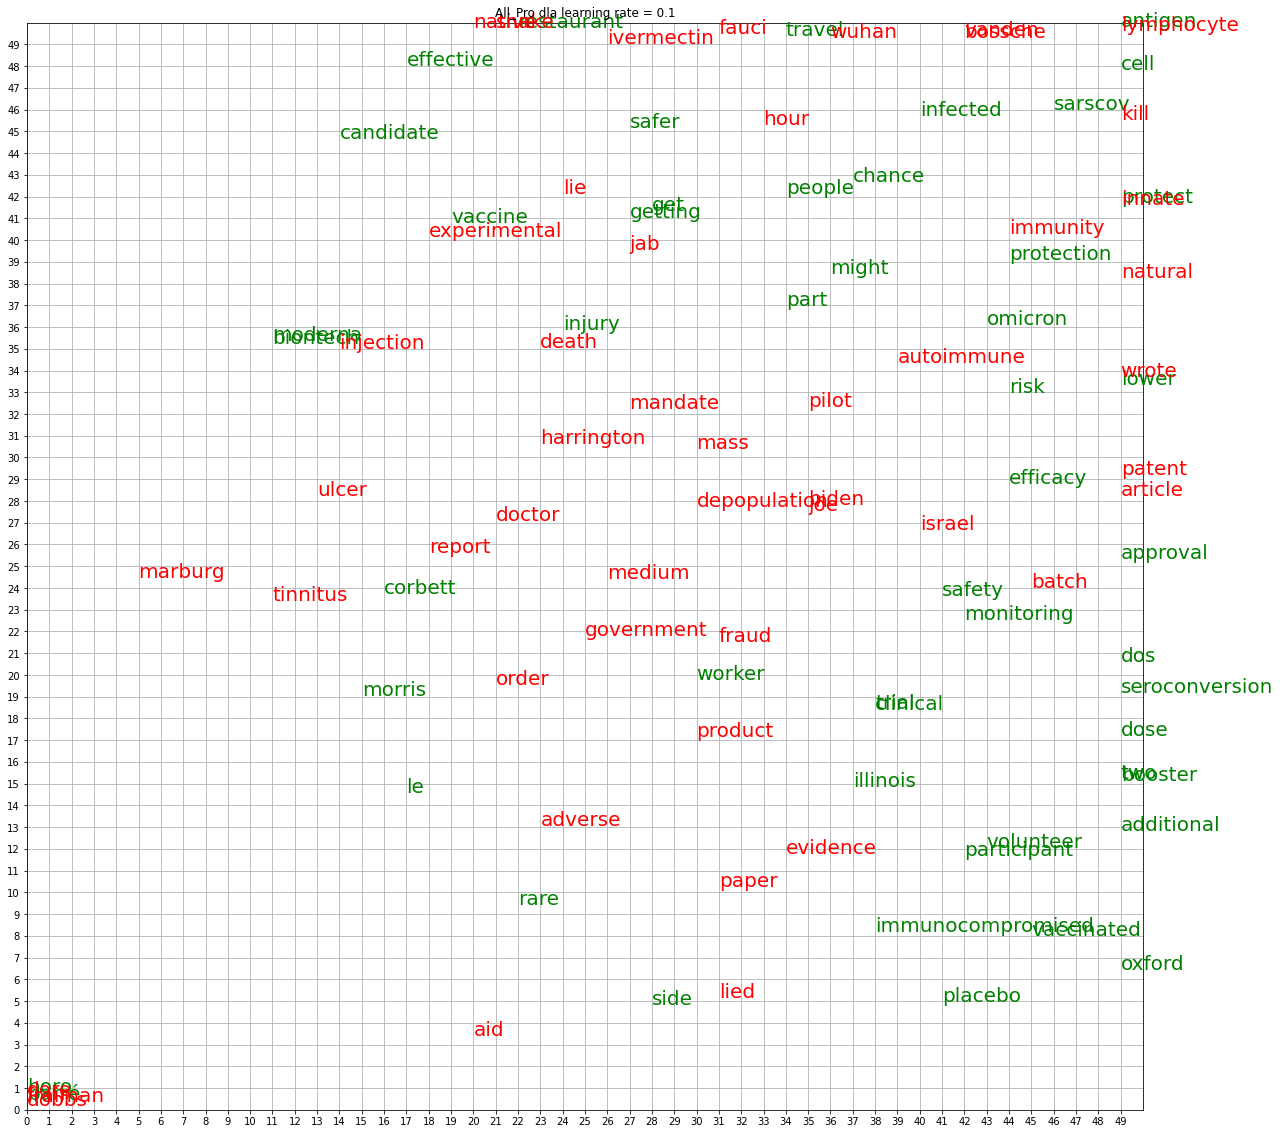

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8138626641174921


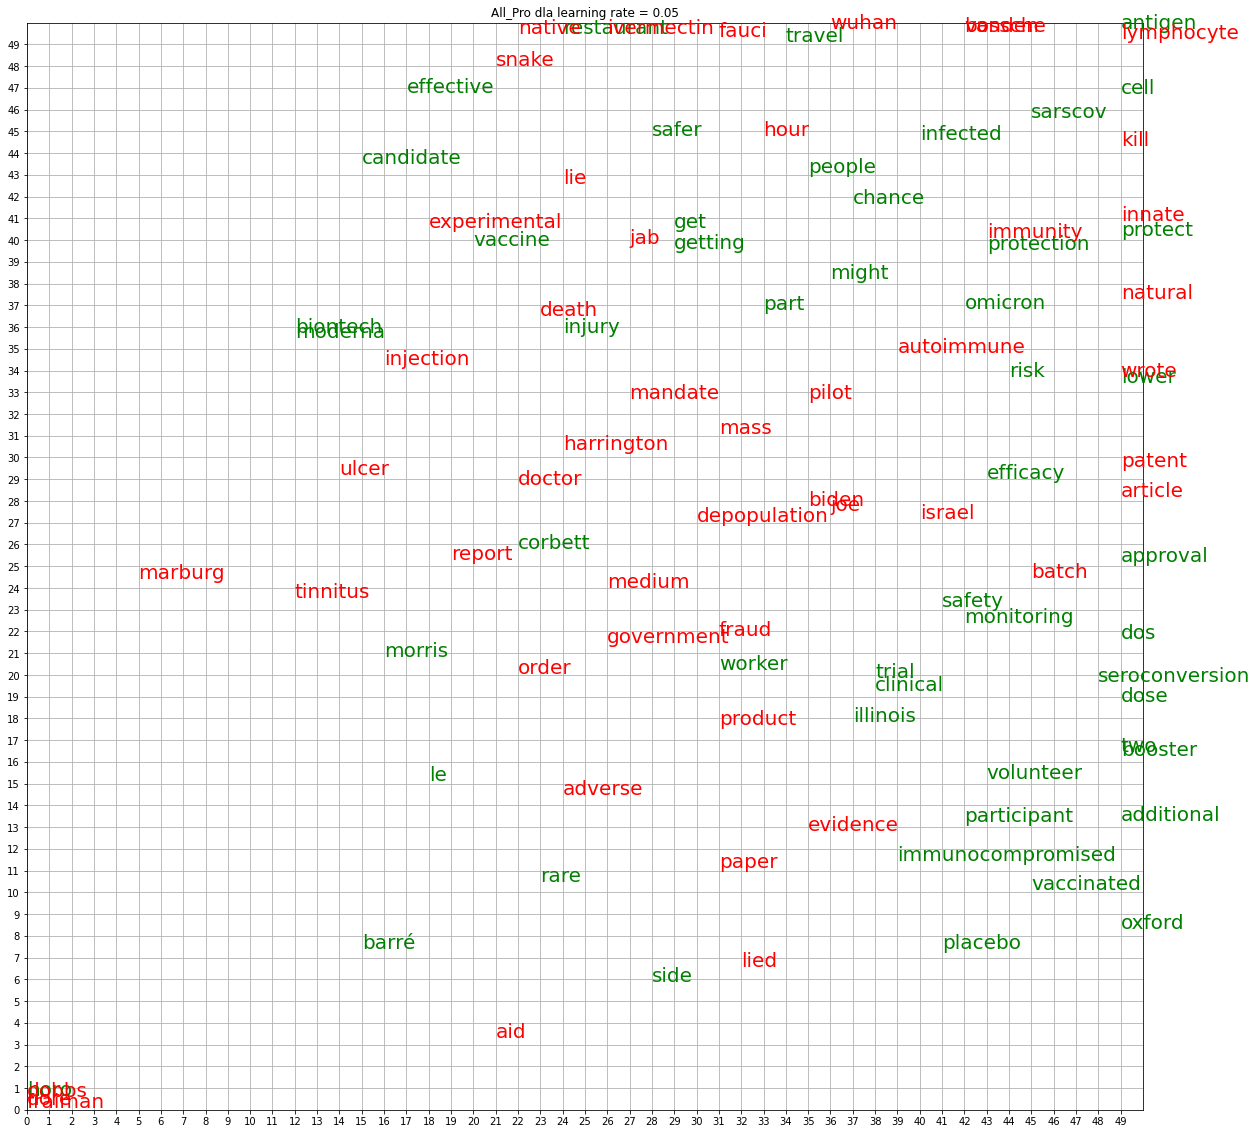

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.7412368593699251


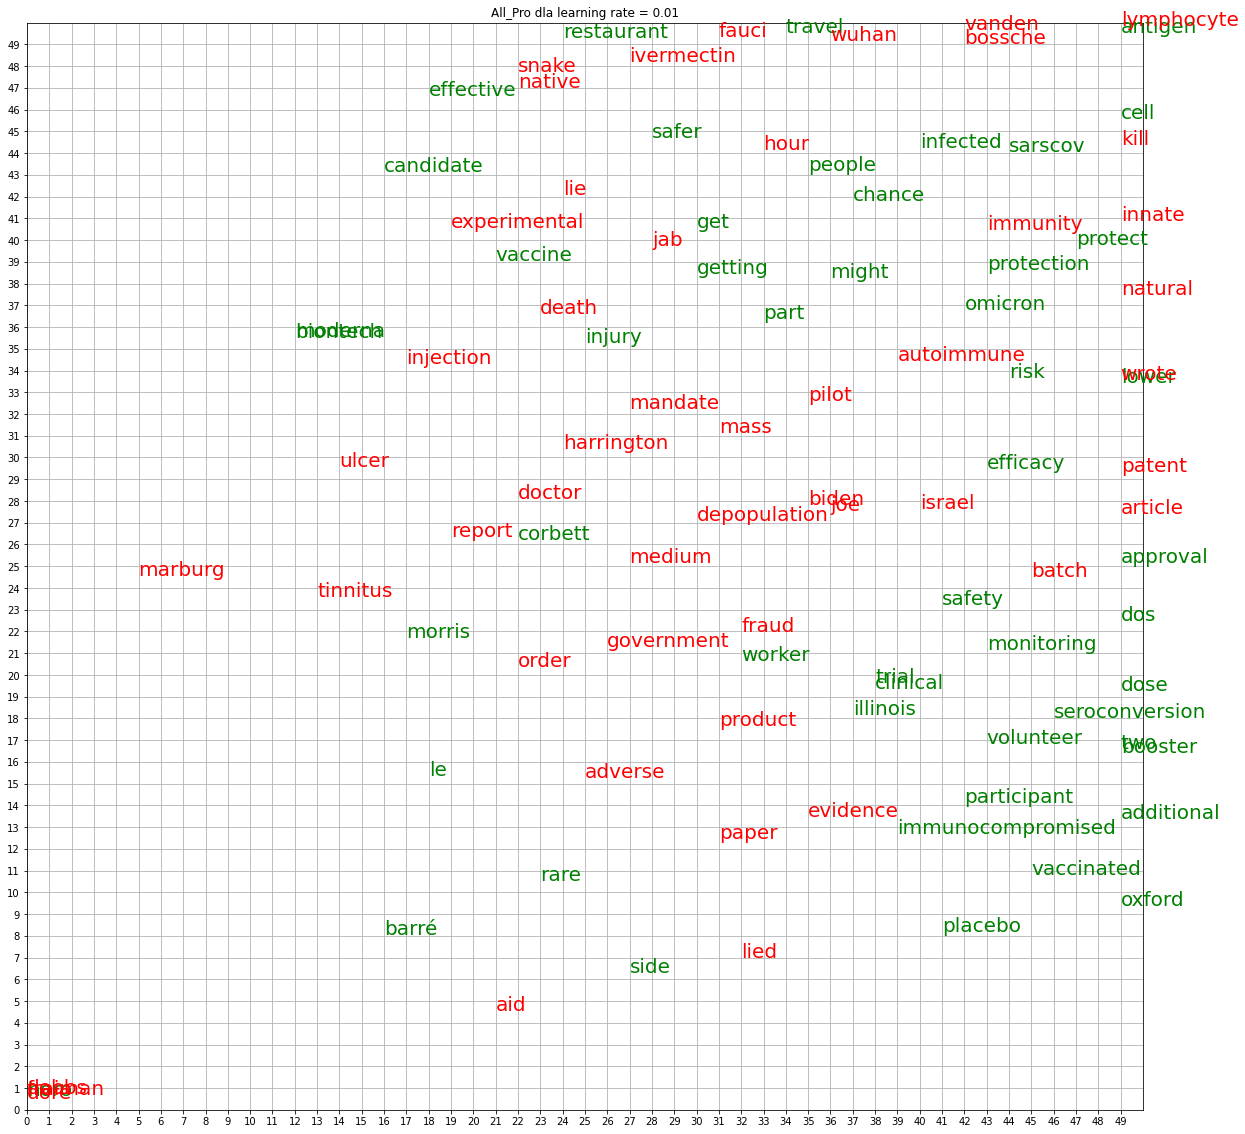

In [40]:
knowledge_init(all_person,all_knowledge_data,"All_Knowledge")
to_read,_ = random_percent(pro_read_data,0.8)
new_simulation(all_person,all_knowledge_data+to_read,"All_Pro")

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.774344735778608


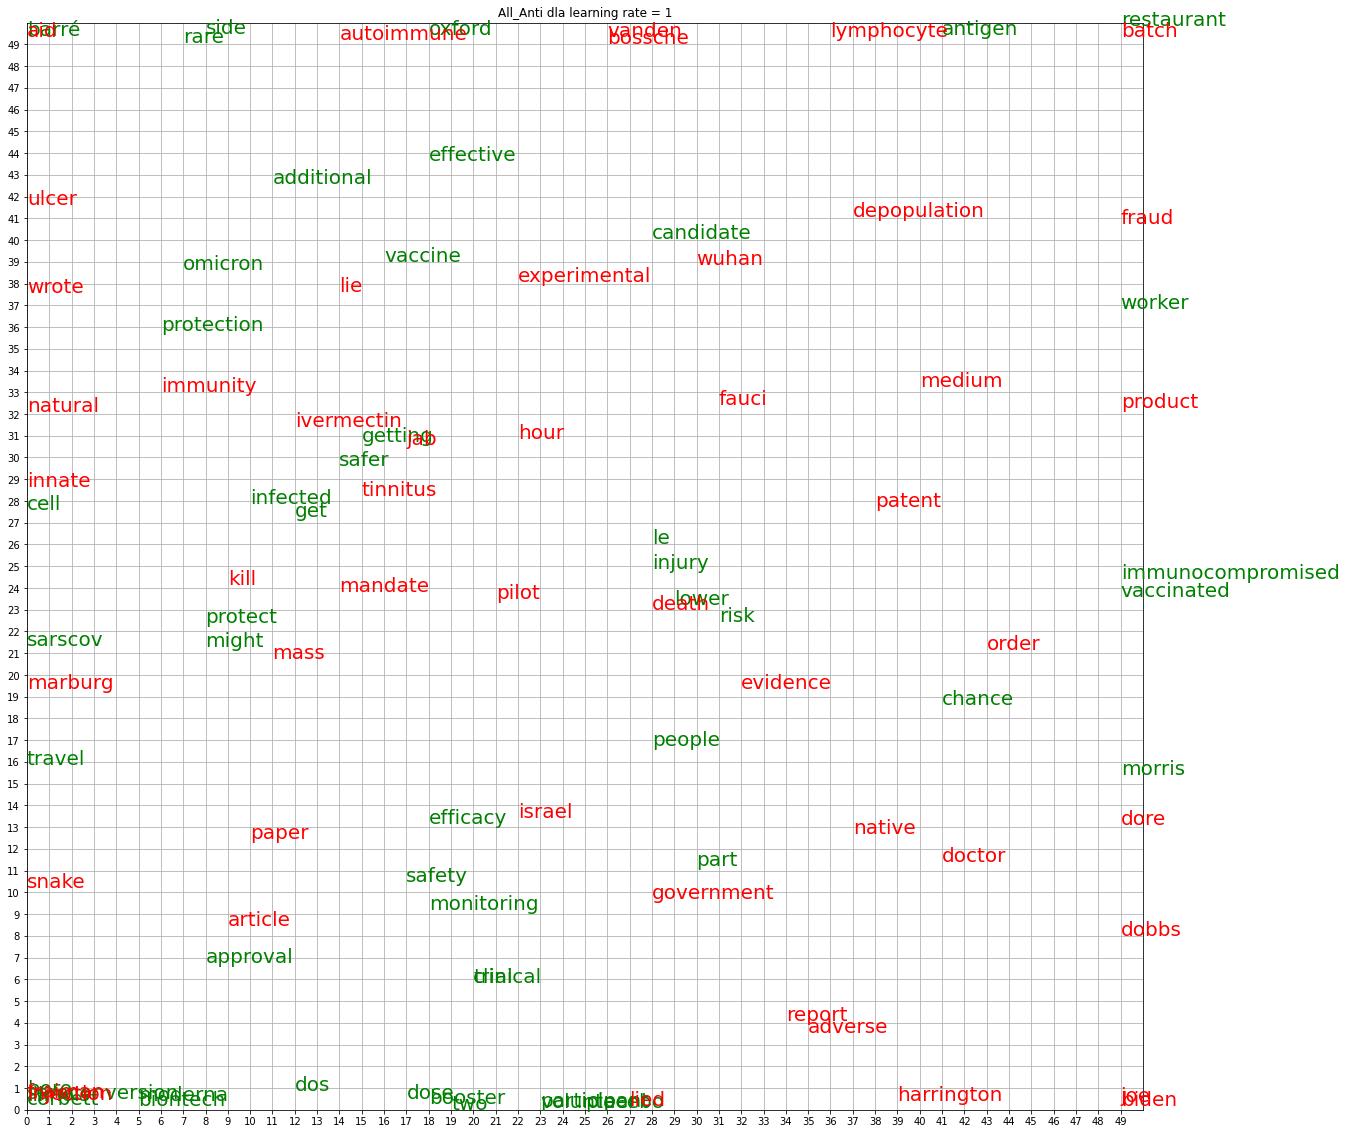

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.7918243610859641


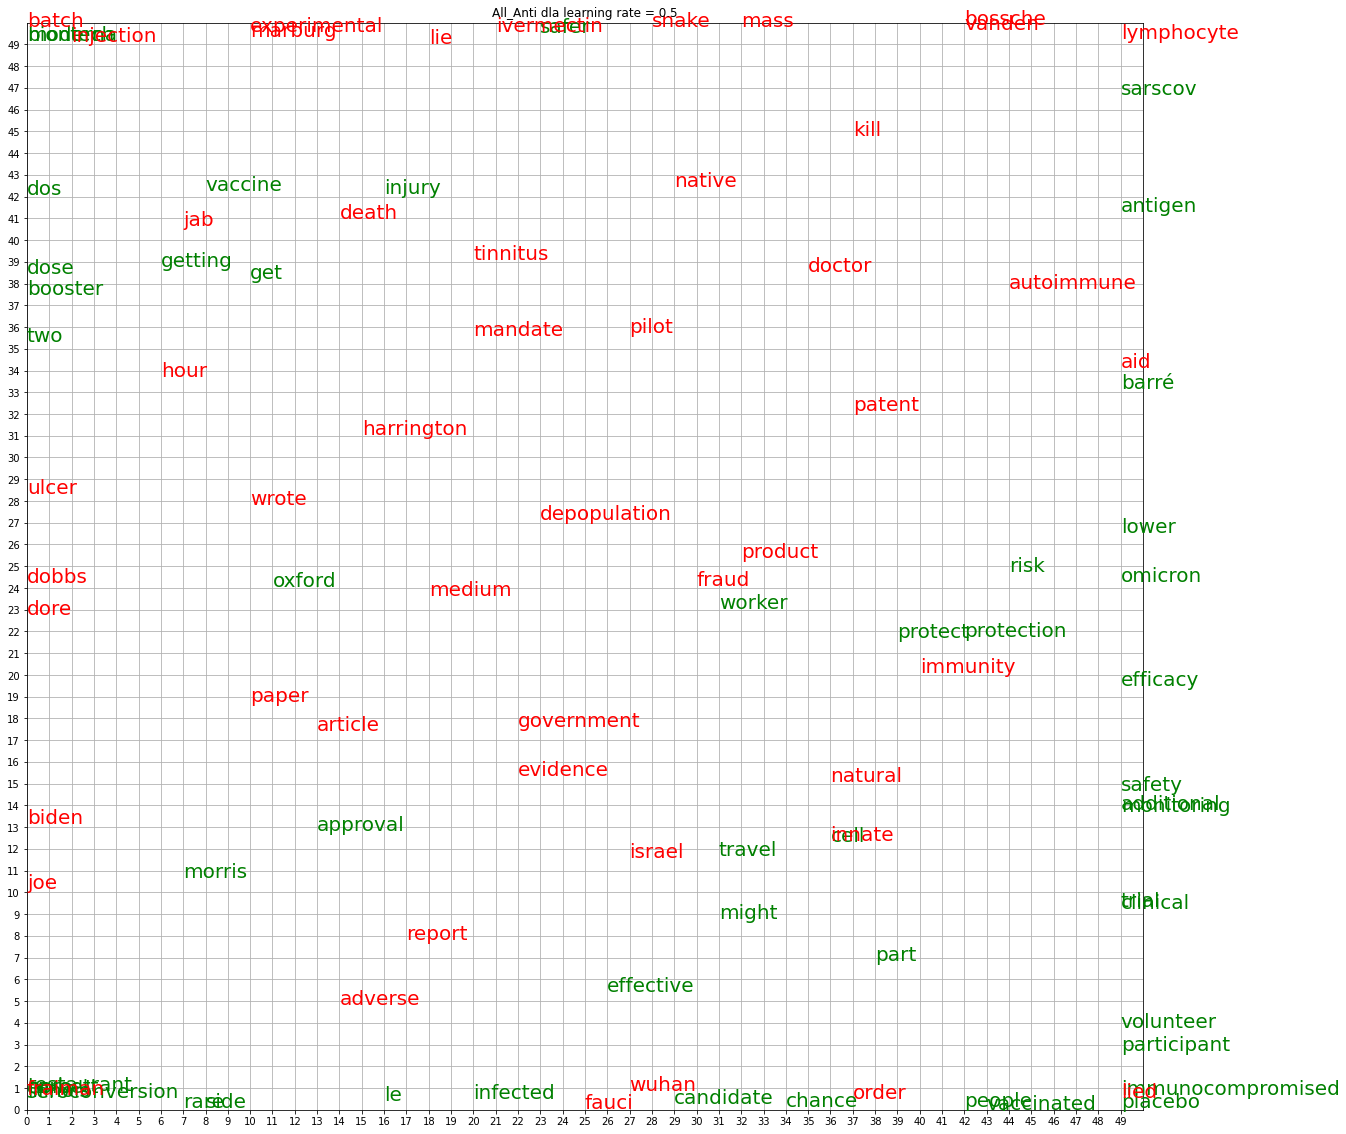

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8212254695606376


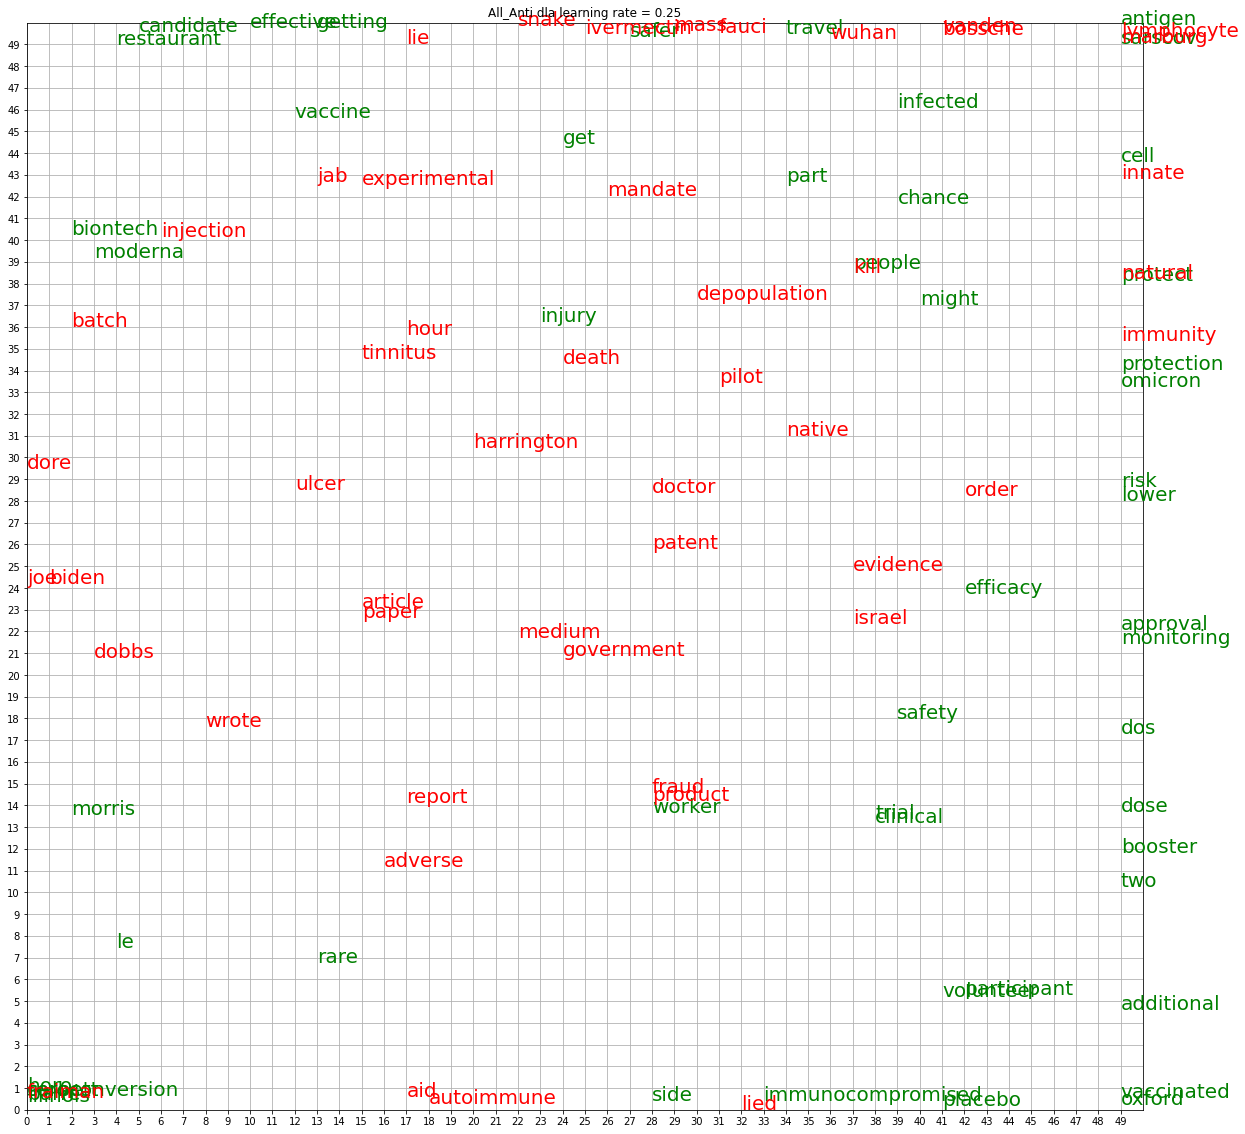

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8396383545400729


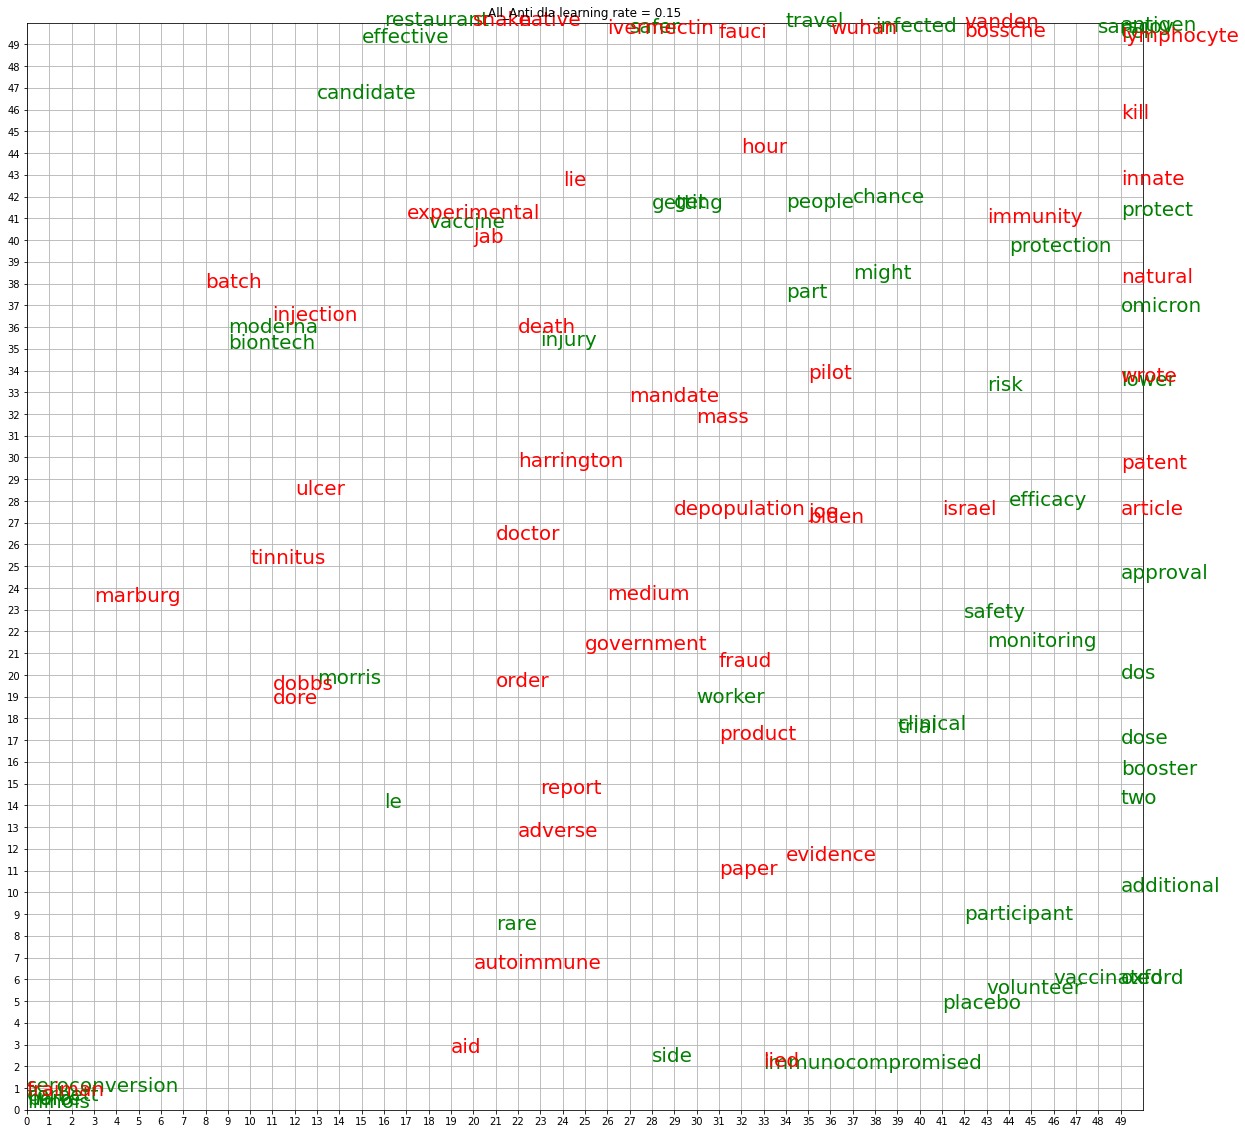

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8384276070083533


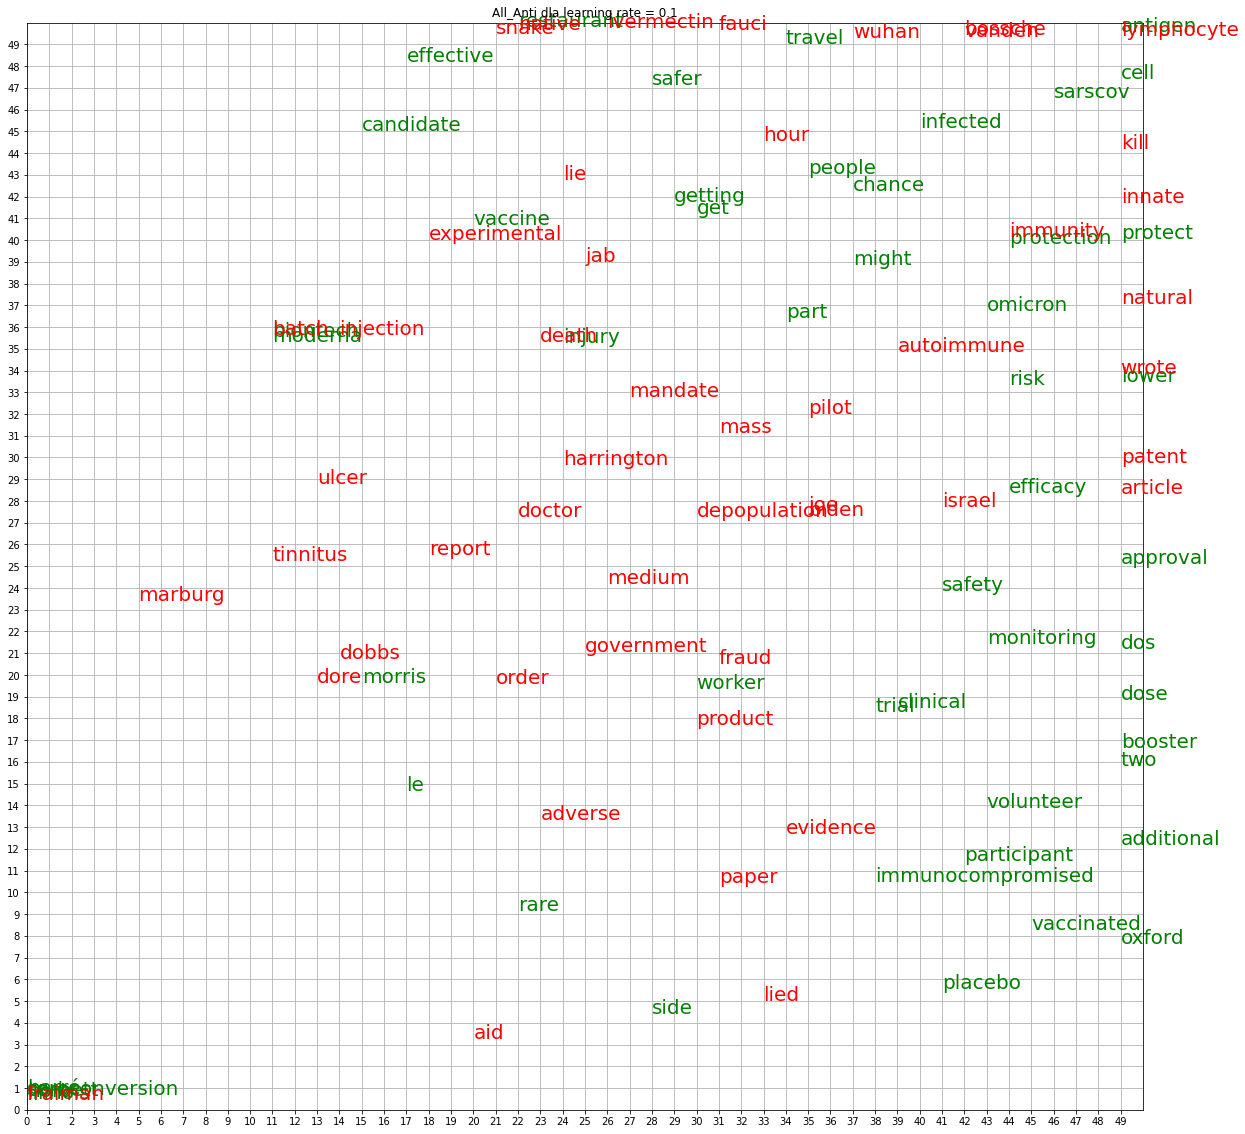

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8115848220421316


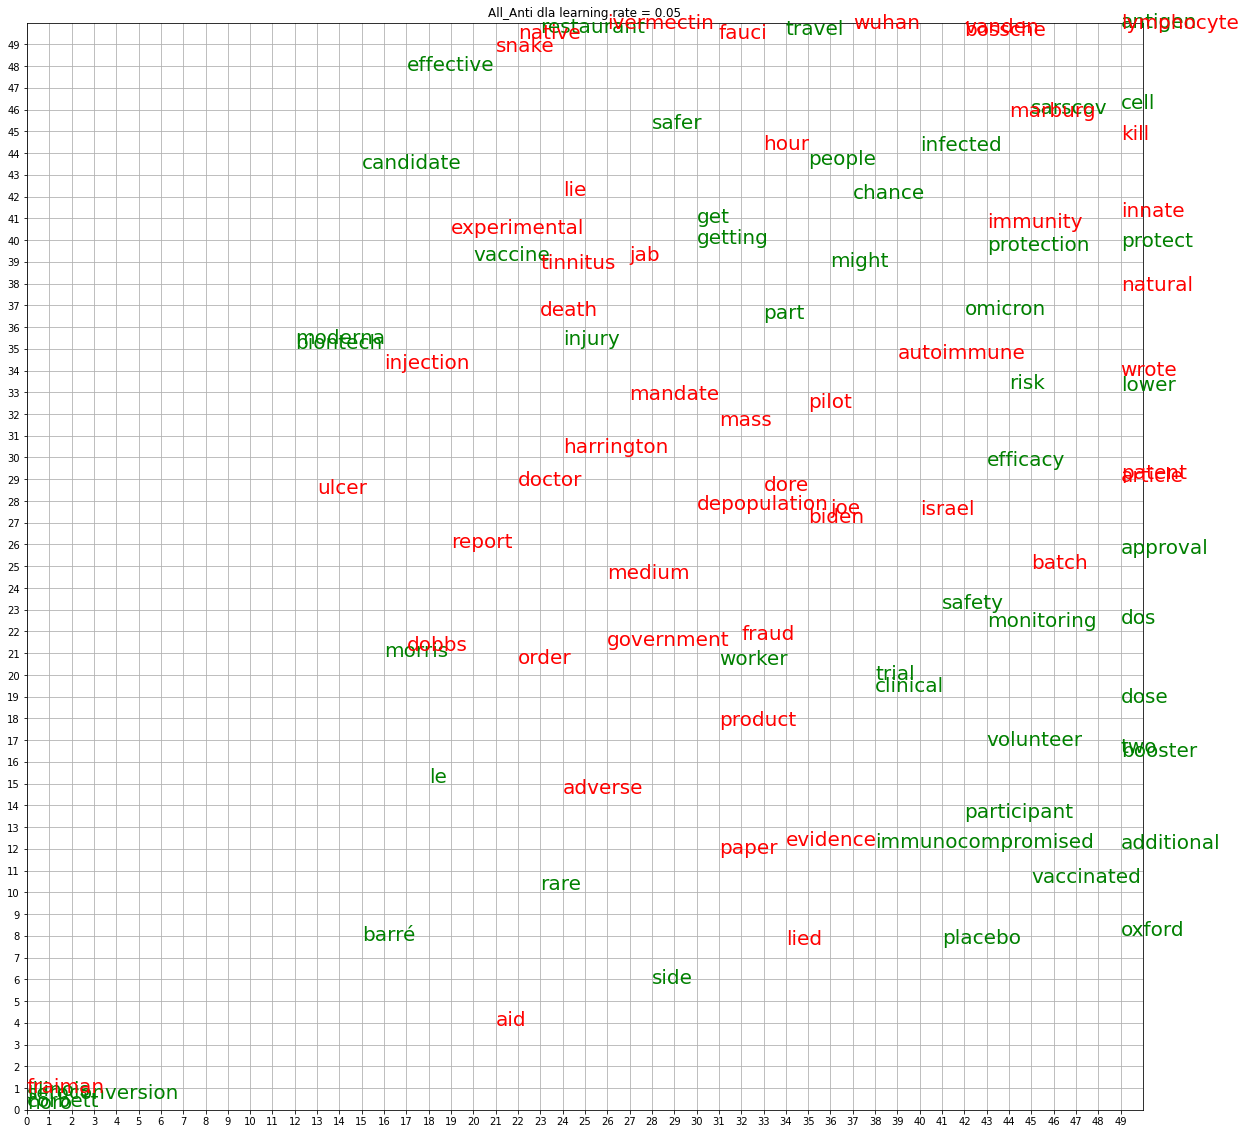

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.7480219759858113


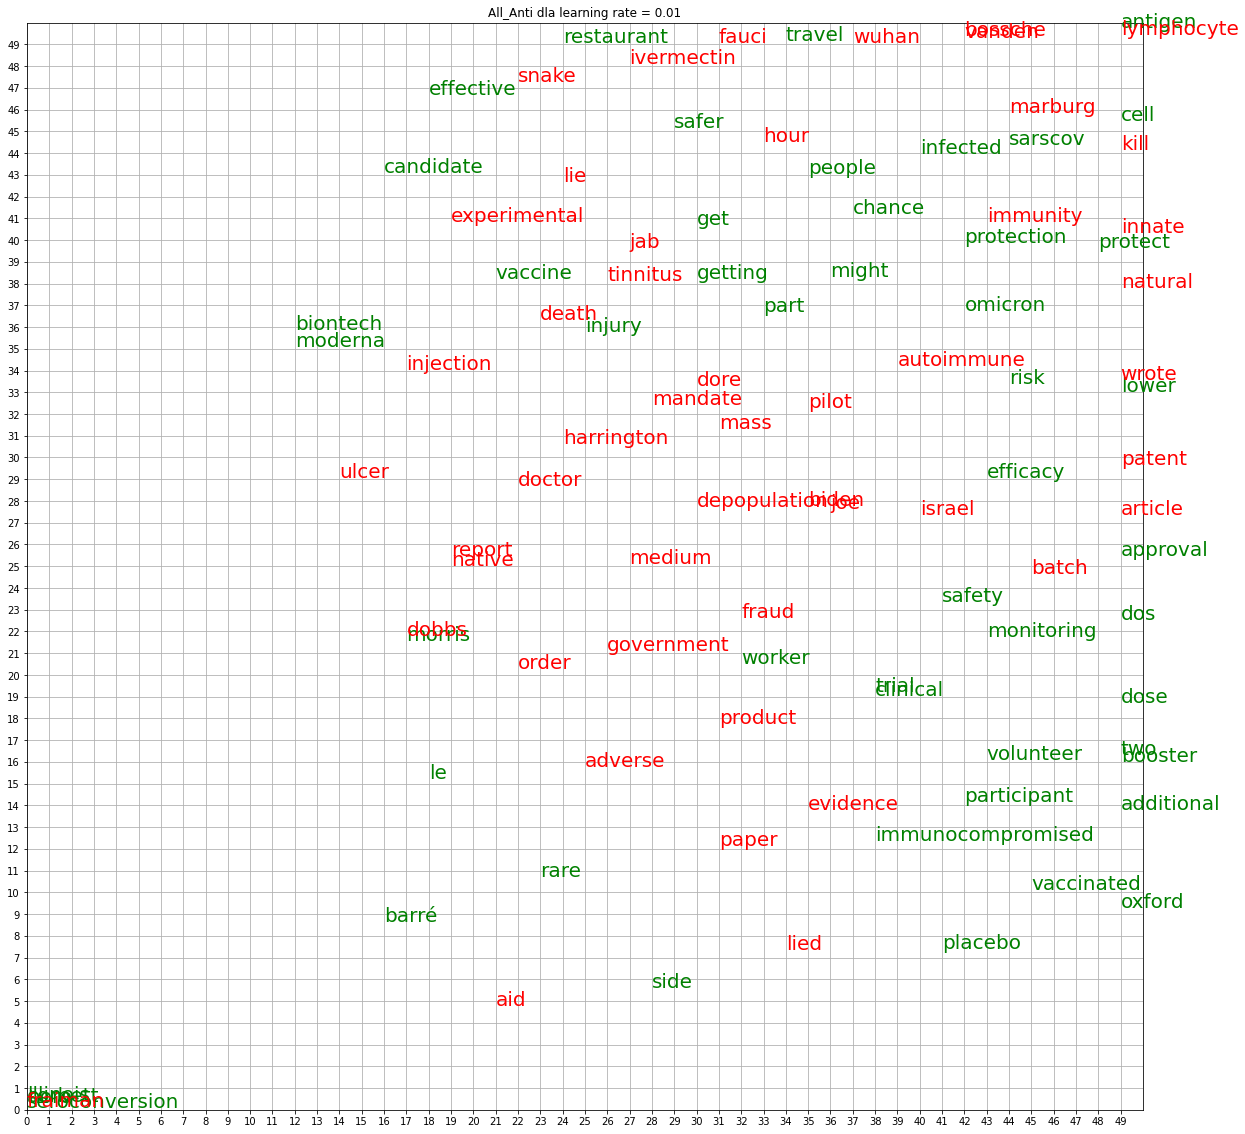

In [41]:
to_read,_ = random_percent(anti_read_data,0.8)
new_simulation(all_person,all_knowledge_data+to_read,"All_Anti")